In [2]:
import pandas as pd
import numpy as np
import math
import sys 
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss F.softmax
import torch.optim as optim #optim.sgd
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy import special
from scipy.stats import truncnorm
import scipy.stats as stats


from locale import format
from dataclasses import dataclass, MISSING
from sklearn import preprocessing #preprocessing.normalize


import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from icecream import ic  # for debugging. print variable name

from PC_param import default_parameters_network # To get the parameters
pars = default_parameters_network()

{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[ 0.00034248],
       [-0.0002801 ],
       [-0.00036025],
       [ 0.00030441]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


## Functions

In [3]:
""" Plot HeatMap of firing rate function"""
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()
    plt.show()


""" Filters gauss and Dog and LoG"""
def gaussian_filter(s, N):
    pop = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    pop = np.arange(1, N + 1)
    gaussIn = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog

def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig



def truncated_normal(N, mu=0., sigma= .1):
    sigma = 1/np.sqrt(N)
    lower, upper = 0., np.inf
    pop = np.arange(1, N + 1)
    
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    #x = np.linspace(0, size, size)

    return X.pdf(pop- pop[:, np.newaxis])#X.rvs(N)


def init_random_matrix(N, mu = 0.):

    lower, upper = 0., np.inf
    sigma = 1/np.sqrt(N)#random.randint(1, 30), random.uniform(0.1, 5)
    X = stats.truncnorm(
        (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    rnd_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)
    return rnd_matrix 


"""
 Normalization or transform to probability
"""

def make_it_proba(r_e):
    eps = torch.FloatTensor([sys.float_info.epsilon]) #torch.FloatTensor
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)


''' Classic Normalization
use:
#preprocessing.normalize(re_numpy, axis= 0)[20,:].sum()

or use:
'''
def normalize(x):
    N = (x - x.min()) / (x.max() - x.min())
    return N


"""
Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""
def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation

def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  
    return torch.tensor(y)

def replace_argmax(r):
    # along some dimension (e.g., the last dimension).
    indices = torch.arange(r.shape[-1]).to(r.device)
    return torch.gather(indices, dim=-1, index=torch.argmax(r, dim=-1)).max()




""" Target design: Get the expected stimuli and then create a matrix of 1 where stimuli 0 elsewhere"""

def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1) #consider replacing argmax by replace_argmax
    Xmax = torch.max(Xargmax)
    return Xmax

def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable
    
    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)# replace where function by relu functio which is differentiable
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d



""" 
Optimization function
Make a function which save parameters of trained model and upload the new model with the updated parameters
"""

def model_with_saved_trained_param(old_model, optimizer, Model, param, sim, dicJ):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model(param, sim, dicJ)
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    if old_model.Jee == new_mymodel.Jee:
        print("it works")
    print("old model Jee:",old_model.Jee,"new model Jee:", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer


def load_weights(newmodel, modelpath): #string
        if '.pt' not in modelpath:
            modelpath += '.pt'      
        newmodel.load_state_dict(torch.load(modelpath))
        #new_mymodel = Model(param, sim, model.state_dict())
        return newmodel #, newmodel.state_dict() to access the param
    
def save_weights(oldmodel, modelpath, epoch=None):  #string
    if '.pt' not in modelpath:
            modelpath += '.pt'
    torch.save(oldmodel.state_dict(), modelpath)

    

"""
Model evaluation

function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
"""
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



""" 
LOSS
"""

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)




""" 
Run simulation over batchXtime
"""

def run_model_across_batch(Input, len_sim, model_instance):
    count = 0 
    P0 = torch.zeros_like(Input)  
    I0 = torch.zeros_like(Input)
    dPdt = torch.zeros_like(Input)  
    model_instance.initiate_state()

    for i in range(Input.shape[0]):
            count +=1
            P0[i,:], I0[i,:], dPdt[i,:], dridt, ampa, gaba = model_instance.forward(Input[int(i),:])#.item()
            if count == len_sim: #train_IN.shape[1]: #if we end the simulation time and go to the next batch
                count = 0
                model_instance.initiate_state()

    return P0, I0, dPdt





""" 
Plot Normalised predictions
"""
def plot_normalized_plot(P0, Ptrained, t, legend = None): #legend = list of 2 strings 
    P0_np = np.array(P0.detach().numpy())
    PT_np = np.array(Ptrained.detach().numpy())

    P0_norm = preprocessing.normalize(P0_np, axis= 1) 
    PT_norm = preprocessing.normalize(PT_np, axis= 1) 
    if legend is None:
        plt.plot(np.arange(P0_norm.shape[1]), P0_norm[t,:], label = f"{t}ms, untrained")
        plt.plot(np.arange(PT_norm.shape[1]), PT_norm[t,:], label = f"{t}ms, trained")
    else:
        plt.plot(np.arange(P0_norm.shape[1]), P0_norm[t,:], label = f"{t}ms," + legend[0])
        plt.plot(np.arange(PT_norm.shape[1]), PT_norm[t,:], label = f"{t}ms," + legend[1])



## Class

### Simple Class

In [4]:

# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°
    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']
    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    #°°° Hard encode these parameters °°°
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    #N=20, sIn=.1, sOut=3., sEI=.2
    def __init__(self, sEI=.2, sIn=.1, sOut=3., N=20):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("Time step of the simulation (dt):", self.dt, "  Duration of simulation (T):", self.T,"s",
              "  Length of the time frame (Lt):", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0, dur=0.05):#ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0
        self.N = param.N

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f: #+2 to not lose dimension ! becareful! 
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt)+2, 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1
      
    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, f_stim=None, InMax=None, In0=None):
        paramf = np.arange(1, self.N+1)
        
        #mask the ground truth f_stim by a gaussian function
        w = np.exp(-(((paramf) - (self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N
        #ic((w).shape)
        #if I want to normalize w:
        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N +1, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))
        
        In_short = In
        range_sim = np.arange(1, In_short.shape[0] + 1)
        len_sim = len(range_sim)
        self.In = In_short
        self.w = w
        self.sigmaIn = sigmaIn

        return In_short, range_sim, len_sim ,w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI,"s","  Size In", self.In.shape, "Size w:",
              self.w.shape, "  f_stim = total length simulation:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




#  °°° Data preparation °°°
        
""" 
1- create a big dataset for every stimuli input. In = X stimulus
2- Split In / X into train and test dataset: Split 70% into train dataset and 30% into test dataset
3- get expected Y / Target
4- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor (Input and Target)
 """

class Batch:
    def __init__(self, param, simu,len_sim):
     # 1  \\\\\\\\\\\ BIG Bottom up sensory input
        self.N_short = param.N # - 6
        self.IN= torch.zeros(len_sim, self.N_short ,self.N_short)
        self.get_sensory_input(param,simu)
        

    def get_sensory_input(self, param, simu):
        for i in range(0, self.N_short):
            index = i+1
            st = Stim(param,simu, dur=simu.T,f =[index], ISI=0) 
            In, _,_,_,_ =st.sensoryInput(param, simu, sigmaIn = 2.)
            self.IN[:,:, i] = torch.tensor(In)
            #sti = torch.tensor(In).float()

    # 2
    def train_test_dataset(self):
        #create a random list containing each of our stimuli types
        num_stimuli = self.IN.shape[2]
        rand_idx = np.arange(0, num_stimuli)
        rng = np.random.default_rng(1245)
        rng.shuffle(rand_idx)

        # split this random list into test and train index. and filter the IN with those indexes
        val_split_index = int(np.floor(0.7 * num_stimuli))
        test_idx, train_idx = rand_idx[val_split_index:], rand_idx[:val_split_index]
        
        train_IN = self.IN[:,:, train_idx].permute(2,0,1)
        test_IN = self.IN[:,:, test_idx].permute(2,0,1)

        return train_IN, test_IN

    # 3
    def get_Targets(self, Inputs):
        Targets = torch.zeros_like(Inputs)
        num_stimuli, _,_ = Inputs.shape
        for stim_idx in range(num_stimuli):
            Targets[stim_idx,:,:] = get_expected_Y_relu(Inputs[stim_idx,:,:])
        return Targets

    # 4
    def create_dataloader(self, Inputs, Targets):   
        dataset = TensorDataset(Inputs, Targets)
        return DataLoader(dataset, batch_size=1, shuffle = True) #one sample per batch

    # 5
    def preprocess_data(self):

        train_IN, test_IN = self.train_test_dataset()
        #get expected target for every stimuli type /batch
        train_Targets = self.get_Targets(train_IN) 
        test_Targets = self.get_Targets(test_IN) 

        train_dataloader = self.create_dataloader(train_IN, train_Targets)
        test_dataloader = self.create_dataloader(test_IN, test_Targets)
        return train_dataloader, train_Targets, train_IN, test_dataloader, test_Targets, test_IN
    
    #6
    def safety_plot(self, train_IN, train_Targets):  
        X_proba = make_it_proba(train_IN[4,:,:])
        Y = train_Targets[4,:,:]
        N = X_proba.shape[1]      
        t=48
        plt.plot(torch.arange(1, N+1), X_proba[t,:], label= f"Proba Input at t={t}") #not in proba
        plt.plot(torch.arange(1, N+1), Y.detach().numpy()[t,:], label = f"target at t={t}") #in proba
        plt.legend()



class Batch_for_NLLL:
    def __init__(self, IN):
        self.Input =  IN
        BatchxTime = self.Input.shape[0]*  self.Input.shape[1]
        self.Target_index = torch.zeros(BatchxTime)
        self.make_Target_index(self.Input)
        
        self.Input_reshaped = self.Input.reshape(self.Input.shape[0]*  self.Input.shape[1], self.Input.shape[2])
    
    def make_Target_index(self, Input):
        time_stim = 0
        for batch in range(0, Input.shape[0]):
            for time in range(0, Input.shape[1]):
                self.Target_index[time + time_stim] = get_stimuli_input(Input[batch,:,:]).item()
            time_stim += Input.shape[1]



# °°° Stopping criterion for the loss °°°

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("--- loss is not improving - training will stop ---")
                return True
        return False
        


### Classs Model

In [5]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class Model(nn.Module):
    def __init__(self, param, sim, dicJ, In):
        super(Model, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = sim.dt #torch.tensor(1e-4) #
        self.N = In.shape[1]#param.N - 6 #20
        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(param.hme)#78.67)
        self.ai = torch.tensor(param.ai)#21.97)
        self.bi = torch.tensor(param.bi)#-4.81)
        self.hmi = torch.tensor(param.hmi)#125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        wei_o = init_random_matrix(N=param.N)
        self.wei = nn.Parameter(torch.tensor(wei_o, requires_grad = True, dtype = torch.float32))
        #self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        
        # Example usage for w0 initialization
        wie_o = init_random_matrix(N=param.N)
        self.wie = nn.Parameter(torch.tensor(wie_o, requires_grad = True, dtype = torch.float32))
        
        #self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.dicJ = dicJ #kwargs
        
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True, dtype=torch.float64))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True, dtype=torch.float64))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True, dtype=torch.float64))

        #--- Initialize model variables here
    def initiate_state(self):
        self.prev_r_e = torch.zeros((self.N)) # torch.ones(self.N) shows more obvious results
        self.prev_r_i = torch.zeros((self.N))
        self.prev_s_ampa = torch.zeros((self.N))
        self.prev_s_gaba = torch.zeros((self.N))
        self.dr_e_dt = torch.zeros((self.N))
        self.dr_i_dt = torch.zeros((self.N))
        self.s_ampa = torch.tensor(0.)
        self.i_tot_e = torch.tensor(0.)
        self.i_tot_i = torch.tensor(0.)
		

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
      
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.
        mulaI = a * I_tot
        addB = mulaI + b
        expo = torch.exp(-addB)
        return hm / (1 + expo)
     

    def forward(self, In):
        #--- Compute values of interest
        #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
        s_gaba_wie = self.prev_s_gaba @ self.wie
        s_ampa_wei = self.prev_s_ampa @ self.wei
        s_gaba_wii = self.prev_s_gaba @ self.wii
      
        self.i_tot_e = (self.Jee * self.s_ampa) - (self.Jie * s_gaba_wie) + (self.Jin*  In)
        self.i_tot_i = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

        phi_arr_e = self.phi(self.i_tot_e, self.ae, self.be, self.hme)
        phi_arr_i = self.phi(self.i_tot_i, self.ai, self.bi, self.hmi)

        self.dr_e_dt = (-self.prev_r_e + phi_arr_e) / self.taue
        self.dr_i_dt = (-self.prev_r_i + phi_arr_i) / self.taui

        r_e = self.prev_r_e+ self.dr_e_dt * self.dt
        r_i = self.prev_r_i + self.dr_i_dt * self.dt

        dS_amp_dt = (- self.prev_s_ampa / self.tauAMPA) + r_e
        s_ampa = self.prev_s_ampa+ dS_amp_dt * self.dt

        dS_gab_dt = (- self.prev_s_gaba / self.tauGABA) + r_i
        s_gaba = self.prev_s_gaba + dS_gab_dt * self.dt

        self.prev_r_e = r_e
        self.prev_r_i = r_i
        self.prev_s_ampa = s_ampa
        self.prev_s_gaba = s_gaba


        return self.prev_r_e, self.prev_r_i, self.dr_e_dt, self.dr_i_dt, self.prev_s_ampa, self.prev_s_gaba

### Data preparation: Call class and Create Batch (Input stimuli + target)

In [6]:
# \\\\ Parameters
param = Parameter(N = 30) # N=20

# \\\\ Simulation time: T in s  (2s before)
sim = Simulation(dt=1e-3,T=.0510) 
sim.printSim()

# \\\\ Bottom up sensory input
stimuli = Stim(param, sim, dur=sim.T, f=[8])
In, range_sim, len_sim, w, sigmaIn = stimuli.sensoryInput(param, sim, sigmaIn=2.) #2.
stimuli.printStim()

Time step of the simulation (dt): 0.001   Duration of simulation (T): 0.051 s   Length of the time frame (Lt): 51
frequence of stimulus f: [8]   ISI: 0 s   Size In (51, 30) Size w: (51, 30)   f_stim = total length simulation: (51, 1) sigmaIn: 2.0


In [7]:
"""wie_o = truncated_normal(N=param.N, mu = 0, sigma= 1/np.sqrt(param.N))
wie = nn.Parameter(torch.tensor(wie_o, requires_grad = True, dtype = torch.float64))
wie"""

'wie_o = truncated_normal(N=param.N, mu = 0, sigma= 1/np.sqrt(param.N))\nwie = nn.Parameter(torch.tensor(wie_o, requires_grad = True, dtype = torch.float64))\nwie'

C:\Users\knzga\AppData\Local\Temp\ipykernel_9424\2809098612.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=colorbar_size)


<function matplotlib.pyplot.show(close=None, block=None)>

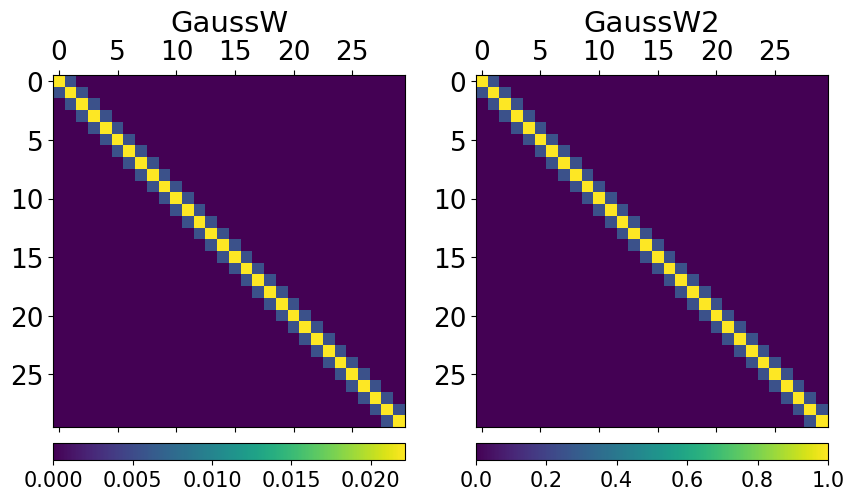

In [8]:
def gaussian_filter(s, N):
    pop = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2

s = .6
pop = np.arange(1, param.N + 1)
n = 1 / (np.sqrt(2 * np.pi) * param.N * s)
gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW)) 

gaussW.shape
cmap ='viridis'
subtitle_size = 19
colorbar_size = 15
fig, ax = plt.subplots(1,2, figsize = (10, 5))
cax = ax[0].matshow(gaussW, cmap = cmap)#.tick_params(labelsize = 10)
# change the label size 
cax.figure.axes[0].tick_params(axis="both", labelsize=subtitle_size) 
ax[0].set_title("GaussW", size = subtitle_size +2)

cax2 = ax[1].matshow(gaussW2, cmap = cmap).figure.axes[1].tick_params(axis="both", labelsize=subtitle_size) 
#cax2.figure.axes[1].tick_params(axis="both", labelsize=subtitle_size) 
ax[1].set_title("GaussW2", size = subtitle_size+2)
fig.colorbar(cax,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=colorbar_size)  # those fraction and pad magically works to adapt every graph
fig.colorbar(cax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=colorbar_size) 
#clb=plt.colorbar()
#clb.ax.tick_params(labelsize=8) 
plt.show

C:\Users\knzga\AppData\Local\Temp\ipykernel_9424\1912715270.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i][j] = X.rvs(1)


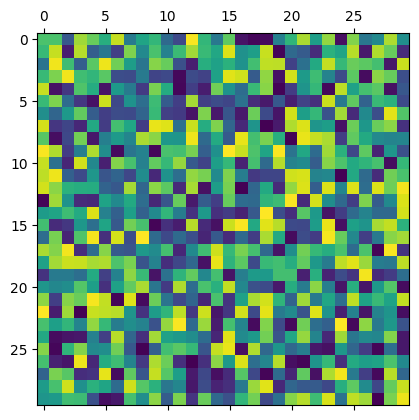

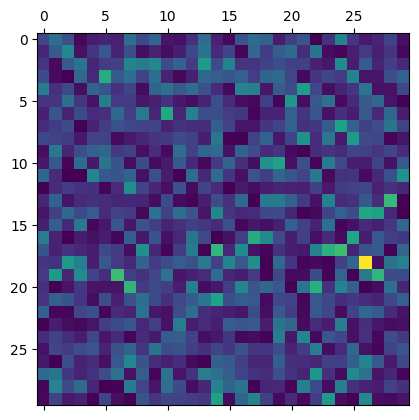

In [9]:
lower, upper = 0., np.inf
mu, sigma = 0, 1/np.sqrt(param.N)#random.randint(1, 30), random.uniform(0.1, 5)
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

#Xpdf =X.pdf(pop- pop[:, np.newaxis])
#Xrvs= X.rvs(pop- pop[:, np.newaxis])
#Xpdf.shape
#X.rvs(1)
"""
cmap = 'magma'
fig, ax = plt.subplots(1,2, figsize = (10, 5))
ax1 = ax[0].matshow(Xpdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax[0].set_title(f"truncated pdf, sigma ={sigma}", size = subtitle_size-4)
ax2 = ax[1].matshow(gaussW2, cmap = cmap).figure.axes[1].tick_params(axis="both", labelsize= 10) 
ax[1].set_title("Initial Gaussian filter", size = subtitle_size-4)
fig.colorbar(ax1,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
plt.show
"""


matrix1 = np.zeros((param.N, param.N))
for i in range(param.N):
    for j in range(param.N):
        matrix1[i][j] = np.random.uniform(low=0.0, high=1.0, size=None) #X.rvs(1)

plt.matshow(matrix1)



matrix = np.zeros((param.N, param.N))
for i in range(param.N):
    for j in range(param.N):
        matrix[i][j] = X.rvs(1)

plt.matshow(matrix)


In [10]:
"""lower, upper = 0., np.inf
Num = 130
mu, sigma = 0, .1#random.randint(1, 30), random.uniform(0.1, 5)
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
data = X.rvs(Num)

N = stats.norm(loc=mu, scale=sigma)
data2 = N.rvs(Num)

fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(data, density=True)
ax[1].hist(data2, density=True)
plt.show()"""

'lower, upper = 0., np.inf\nNum = 130\nmu, sigma = 0, .1#random.randint(1, 30), random.uniform(0.1, 5)\nX = stats.truncnorm(\n    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)\ndata = X.rvs(Num)\n\nN = stats.norm(loc=mu, scale=sigma)\ndata2 = N.rvs(Num)\n\nfig, ax = plt.subplots(2, sharex=True)\nax[0].hist(data, density=True)\nax[1].hist(data2, density=True)\nplt.show()'

In [11]:
#batch_instance.IN[:,3:-3,3:-3].shape

torch.Size([1071]) torch.Size([1071, 30]) torch.Size([21, 51, 30])


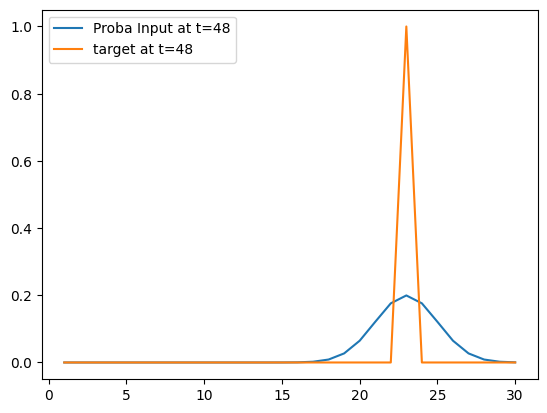

In [12]:
batch_instance = Batch(param=param, simu=sim, len_sim = sim.Lt)
train_dataloader, train_Targets, train_IN, test_dataloader, test_Targets, test_IN = batch_instance.preprocess_data()
batch_instance.safety_plot(train_IN,train_Targets)


batch_instance_NLLL = Batch_for_NLLL(train_IN)
Target_idx_NLLL = batch_instance_NLLL.Target_index
Input_NLLL =batch_instance_NLLL.Input_reshaped

print(Target_idx_NLLL.shape, Input_NLLL.shape, train_IN.shape)

In [13]:
# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())
print(J1['Jee'], J_list)
model = Model(param=param, sim=sim, dicJ=J1, In = In)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

P0, I0, dP0dt = run_model_across_batch(Input_NLLL, len_sim, model)
#P0 = P0[:,3:param.N-3] # remove the 3 last populations and 3 firsts one 
#I0 = I0[:,3:param.N-3]
Input_NLLL_short = Input_NLLL[:,3:-3]


0.072 ['Jee', 'Jei', 'Jie', 'Jii', 'Jin']


C:\Users\knzga\AppData\Local\Temp\ipykernel_9424\1040605831.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)


### Get Inputs and Target without pitch [:3, :-3]

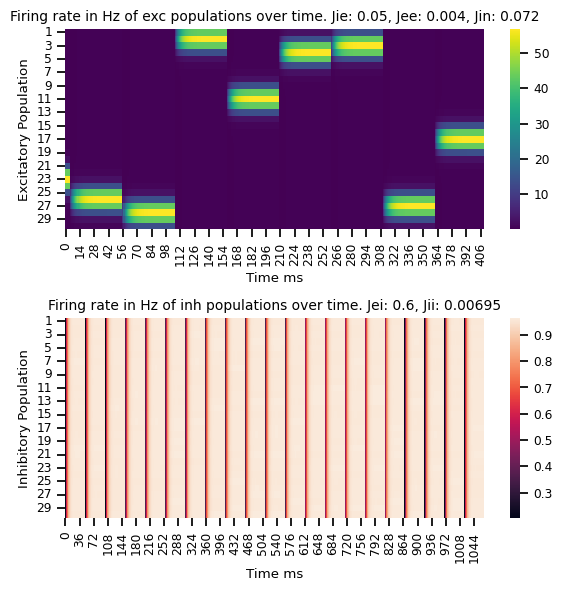

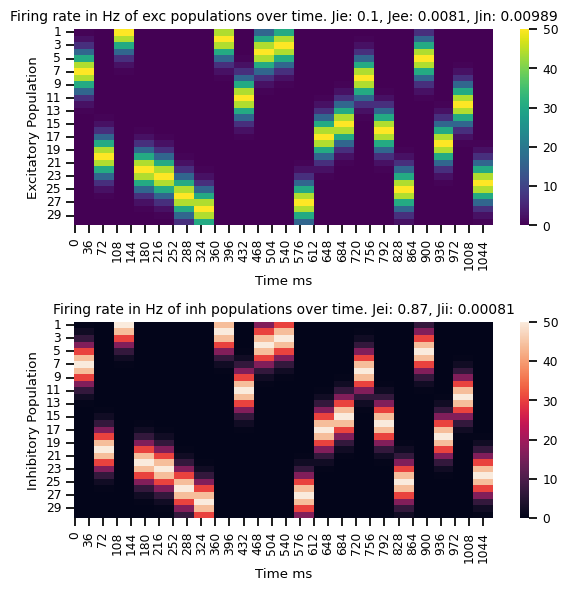

In [14]:
#50
HeatMap(P0[250:660,:].detach().numpy(), I0.detach().numpy(), J1)
HeatMap(Input_NLLL.detach().numpy(), Input_NLLL.detach().numpy())

### loosss

In [15]:
#3/ L2 regu term
"""l2_reg_coef=0.0001
l2_reg = 0.0
for param in mymodel.parameters():
    l2_reg += torch.sum(param**2)

#L2_term = l2_reg * l2_reg_coef
"""

'l2_reg_coef=0.0001\nl2_reg = 0.0\nfor param in mymodel.parameters():\n    l2_reg += torch.sum(param**2)\n\n#L2_term = l2_reg * l2_reg_coef\n'

In [1]:
def custom_loss_(Prediction, Target, derivativeE):
  #1/ Proba term
  criterion = torch.nn.NLLLoss()
  P2 = make_it_proba(Prediction) #
  loss_norm = criterion(P2, Target.long())

  #2/ derivative good 
  #loss_derivative = torch.zeros_like(Target)
  eps = torch.FloatTensor([sys.float_info.epsilon]) 
  Target_idx_np = (Target).numpy().astype(int)
  #loss_derivative = torch.zeros(train_IN.shape[0])
  loss_derivative = torch.zeros_like(Target)
  
  hyperactvity_penalty = torch.zeros(train_IN.shape[0])
  laziness_penalty = torch.zeros(train_IN.shape[0])
  
  count = 0
  i2 = 0
  start = 0
  stop = (len_sim)
  for i, sti_idx in enumerate(Target_idx_np):
      count +=1
      if count == stop:
          time_idx = slice(start, stop)
          #loss_derivative[i2] = - F.softplus(derivativeE[time_idx,sti_idx] ).mean() + F.softplus(derivativeE[time_idx,:sti_idx]).mean() + F.softplus(derivativeE[time_idx,(sti_idx+1):]).mean()
          
          
          if torch.max(Prediction[time_idx,sti_idx]) > 60.: #60
              hyperactvity_penalty[i2] = torch.sum((Prediction[time_idx, sti_idx]**2)) #torch.clamp(r_e[:, 7], max=10.0
              #ic(hyperactvity_penalty[i2])
          else:
              hyperactvity_penalty[i2] = 0
             #ic(hyperactvity_penalty[i2])
              
          if torch.max(Prediction[time_idx,sti_idx]) < 10.: #60
              laziness_penalty[i2] = torch.sum(1 / torch.clamp(Prediction[time_idx, sti_idx]**2, min = eps)) #torch.clamp(r_e[:, 7], max=10.0

          else:
              laziness_penalty[i2] = 0
              #activity_threshold = 10.0  # Adjust as needed
              # Calculate low_activity_penalty using the inverse of the activity
              #low_activity_penalty[i2] = torch.sum(1.0 / torch.clamp(Prediction[time_idx, sti_idx], min=activity_threshold))

              #ic(hyperactvity_penalty[i2])
             #ic(hyperactvity_penalty[i2])
          
          i2 += 1
          start = stop
          stop += len_sim
          """
          """
  
  """len_sim_test = len_sim
  count = 0
  start = 0
  i2 = 0
  for i, sti_idx in enumerate(Target_idx_np):
      count += 1
      if count == len_sim_test:
          # time_ind = slice(count, len_sim_test)
          loss_derivative[i2] = - F.softplus(derivativeE[start:len_sim_test,sti_idx] ).sum() + F.softplus(derivativeE[start:len_sim_test,:sti_idx]).sum() + F.softplus(derivativeE[start:len_sim_test,(sti_idx+1):]).sum()
          #ic(loss_derivative[i])
          start = count
          len_sim_test += len_sim
          #ic(start, len_sim_test)
          i2 += 1"""

  len_sim_test = len_sim
  count = 0
  start = 0
  for i, sti_idx in enumerate(Target_idx_np):
    count += 1
    if count == len_sim_test:
        loss_derivative[i] = - F.softplus(derivativeE[start:len_sim_test,sti_idx] ).sum() + F.softplus(derivativeE[start:len_sim_test,:sti_idx]).sum() + F.softplus(derivativeE[start:len_sim_test,(sti_idx+1):]).sum()
        #ic(loss_derivative[i])
        start = count
        len_sim_test += len_sim_test
  """
  for i, sti_idx in enumerate(Target_idx_np):
    loss_derivative[i] = - F.softplus(derivativeE[:,sti_idx] ).sum() + F.softplus(derivativeE[:,:sti_idx]).sum() + F.softplus(derivativeE[:,(sti_idx+1):]).sum()
  """
  loss_derivative_term = loss_derivative.mean()
  coef_derivative = 1E-6 #1E-6 #0.00001
  loss_derivative_term = coef_derivative * loss_derivative_term
  
  hyperactvity_penalty_term = hyperactvity_penalty.mean()
  hyperactvity_penalty_coef= 1E-7#1E-6
  hyperactvity_penalty_term = hyperactvity_penalty_term * hyperactvity_penalty_coef
  laziness_penalty = (laziness_penalty.sum() * 0.01)
  #4/ Constraint ws
  wie = list(model.parameters())[0]
  
  be_positive = 0
  for i in wie:
    for j in i:
        if j < 0:
            ic(j)
            be_positive += -j
        else:
            #ic(j)
            be_positive += 0
  
  #be_positive = torch.sum(torch.nn.functional.relu(-model.wie))
  wie = list(model.parameters())[0]
  be_positive = torch.mean(F.relu(- wie))
  """"""
  be_positive = torch.mean(F.relu(- wie))

  Cost = loss_norm + loss_derivative_term + be_positive + hyperactvity_penalty_term + laziness_penalty #+ activity_regularization
  #ic(loss_norm, loss_derivative_term, be_positive,hyperactvity_penalty_term, laziness_penalty)#loss_derivative_term, hyperactvity_penalty_term)
  return Cost

In [16]:
train_Targets_reshaped = train_Targets.reshape(train_Targets.shape[0]*  train_Targets.shape[1], train_Targets.shape[2])

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)

## Optimization

In [18]:
train_Targets.shape
#Target_idx_np.shape[0]/51


torch.Size([21, 51, 30])

In [17]:
class run_optimization:
    def __init__(self, model, Input, T, modelpath ,opti_name = "Adam" ,num_epoch =20, learning_rate =0.0001):
        criterion = torch.nn.NLLLoss()
        logsoft = nn.LogSoftmax(dim=1)
        self.early_stopper = EarlyStopper(patience=15, min_delta=2)#3

        self.losses = torch.zeros(num_epoch)

        if opti_name =="Adam":
            self.optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate)
        elif opti_name == "SGD":
            self.optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate, weight_decay = 0.001)
        
        self.run(criterion, logsoft, model, Input, T, modelpath, num_epoch,learning_rate)

    def run(self, criterion, logsoft, model, Input, T, modelpath, num_epoch, learning_rate): 
        model.initiate_state()
        model.train()
        for epoch in range(num_epoch):
            model.initiate_state()
            self.optimizer.zero_grad()  
            P = torch.zeros(Input.shape)   
            I = torch.zeros(Input.shape) 
            dPdt = torch.zeros_like(Input)  

            count = 0
            for i, b in enumerate(T):
                count +=1
                P[i,:], I[i,:], dPdt[i,:], dridt, ampa, gaba = model(Input[int(i),:])
                if count == len_sim: #train_IN.shape[1]: #if we end the simulation time and go to the next batch
                    count = 0
                    model.initiate_state()

            #P2 = logsoft(P)
            #P2 = make_it_proba(P)
            #loss = criterion(P2, T.long())  #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # #loss = easyLoss(P2, train_Targets_reshaped) #loss = custom_loss_(P, Target_idx_NLLL, dPdt)
            loss = custom_loss_(P, Target_idx_NLLL, dPdt)

            loss.backward()
            self.optimizer.step()
            
            ic(torch.max(P))#, torch.min(P),torch.mean(P))
            #ic(torch.max(P2), torch.min(P2), torch.mean(P2))
            
            if self.early_stopper.early_stop(loss):  
                           
                break
            

            self.losses[epoch] = loss
            print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}, Learning rate:{learning_rate}')#.item()
            #for par in model.parameters():
                #ic(par.grad)
        r = np.round(np.random.rand(),1)
        g = np.round(np.random.rand(),1)
        b = np.round(np.random.rand(),1)
        color_l = [r,g,b]
        plt.plot(np.arange(self.losses.shape[0]), self.losses.detach().numpy(), 'bo', color = color_l, label = f'Loss over {num_epoch}epochs with LR = {learning_rate}')
        plt.legend()
        plt.show()
        if '.pth' not in modelpath:
            modelpath += '.pth' #alejandros has pt
        plt.plot(np.arange(P.shape[1]), P[50,:].detach().numpy(), color = color_l, label = f'firing rate with {learning_rate}')
        plt.legend()
        plt.show()
        HeatMap(P[:50,:].detach().numpy(), I[:50,:].detach().numpy(), J1)
        save_weights(model, modelpath)
        self.color_list = color_l

### RUn training

C:\Users\knzga\AppData\Local\Temp\ipykernel_9424\1040605831.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)
ic| torch.max(P): tensor(56.7429, grad_fn=<MaxBackward1>)


Epoch [1/355], Loss: -0.3119964897632599, Learning rate:0.001


ic| torch.max(P): tensor(40.0706, grad_fn=<MaxBackward1>)


Epoch [2/355], Loss: -0.3246908187866211, Learning rate:0.001


ic| torch.max(P): tensor(27.8823, grad_fn=<MaxBackward1>)


Epoch [3/355], Loss: -0.3176589906215668, Learning rate:0.001


ic| torch.max(P): tensor(29.0336, grad_fn=<MaxBackward1>)


Epoch [4/355], Loss: -0.3191104233264923, Learning rate:0.001


ic| torch.max(P): tensor(35.2229, grad_fn=<MaxBackward1>)


Epoch [5/355], Loss: -0.3238905370235443, Learning rate:0.001


ic| torch.max(P): tensor(42.4841, grad_fn=<MaxBackward1>)


Epoch [6/355], Loss: -0.3244186341762543, Learning rate:0.001


ic| torch.max(P): tensor(47.4367, grad_fn=<MaxBackward1>)


Epoch [7/355], Loss: -0.32212284207344055, Learning rate:0.001


ic| torch.max(P): tensor(48.8676, grad_fn=<MaxBackward1>)


Epoch [8/355], Loss: -0.32109206914901733, Learning rate:0.001


ic| torch.max(P): tensor(47.2966, grad_fn=<MaxBackward1>)


Epoch [9/355], Loss: -0.3222620189189911, Learning rate:0.001


ic| torch.max(P): tensor(43.6236, grad_fn=<MaxBackward1>)


Epoch [10/355], Loss: -0.32416680455207825, Learning rate:0.001


ic| torch.max(P): tensor(39.0378, grad_fn=<MaxBackward1>)


Epoch [11/355], Loss: -0.32492682337760925, Learning rate:0.001


ic| torch.max(P): tensor(35.0908, grad_fn=<MaxBackward1>)


Epoch [12/355], Loss: -0.3240381181240082, Learning rate:0.001


ic| torch.max(P): tensor(33.1174, grad_fn=<MaxBackward1>)


Epoch [13/355], Loss: -0.32301390171051025, Learning rate:0.001


ic| torch.max(P): tensor(33.5037, grad_fn=<MaxBackward1>)


Epoch [14/355], Loss: -0.32328277826309204, Learning rate:0.001


ic| torch.max(P): tensor(35.7853, grad_fn=<MaxBackward1>)


Epoch [15/355], Loss: -0.32439884543418884, Learning rate:0.001


ic| torch.max(P): tensor(39.0375, grad_fn=<MaxBackward1>)


Epoch [16/355], Loss: -0.3250732719898224, Learning rate:0.001


ic| torch.max(P): tensor(42.1365, grad_fn=<MaxBackward1>)


Epoch [17/355], Loss: -0.32480889558792114, Learning rate:0.001


ic| torch.max(P): tensor(44.1422, grad_fn=<MaxBackward1>)


Epoch [18/355], Loss: -0.324203222990036, Learning rate:0.001


ic| torch.max(P): tensor(44.6128, grad_fn=<MaxBackward1>)


Epoch [19/355], Loss: -0.3240360617637634, Learning rate:0.001


ic| torch.max(P): tensor(43.5955, grad_fn=<MaxBackward1>)


Epoch [20/355], Loss: -0.32447484135627747, Learning rate:0.001


ic| torch.max(P): tensor(41.4915, grad_fn=<MaxBackward1>)


Epoch [21/355], Loss: -0.3250686228275299, Learning rate:0.001


ic| torch.max(P): tensor(38.9747, grad_fn=<MaxBackward1>)


Epoch [22/355], Loss: -0.3252626955509186, Learning rate:0.001


ic| torch.max(P): tensor(36.8572, grad_fn=<MaxBackward1>)


Epoch [23/355], Loss: -0.3249802887439728, Learning rate:0.001


ic| torch.max(P): tensor(35.8062, grad_fn=<MaxBackward1>)


Epoch [24/355], Loss: -0.32469597458839417, Learning rate:0.001


ic| torch.max(P): tensor(36.0755, grad_fn=<MaxBackward1>)


Epoch [25/355], Loss: -0.3248228430747986, Learning rate:0.001


ic| torch.max(P): tensor(37.4546, grad_fn=<MaxBackward1>)


Epoch [26/355], Loss: -0.3252173364162445, Learning rate:0.001


ic| torch.max(P): tensor(39.3919, grad_fn=<MaxBackward1>)


Epoch [27/355], Loss: -0.3254508078098297, Learning rate:0.001


ic| torch.max(P): tensor(41.1998, grad_fn=<MaxBackward1>)


Epoch [28/355], Loss: -0.32536229491233826, Learning rate:0.001


ic| torch.max(P): tensor(42.3025, grad_fn=<MaxBackward1>)


Epoch [29/355], Loss: -0.325181782245636, Learning rate:0.001


ic| torch.max(P): tensor(42.4175, grad_fn=<MaxBackward1>)


Epoch [30/355], Loss: -0.32519128918647766, Learning rate:0.001


ic| torch.max(P): tensor(41.5947, grad_fn=<MaxBackward1>)


Epoch [31/355], Loss: -0.3254113793373108, Learning rate:0.001


ic| torch.max(P): tensor(40.1660, grad_fn=<MaxBackward1>)


Epoch [32/355], Loss: -0.3256238102912903, Learning rate:0.001


ic| torch.max(P): tensor(38.6477, grad_fn=<MaxBackward1>)


Epoch [33/355], Loss: -0.32564622163772583, Learning rate:0.001


ic| torch.max(P): tensor(37.5752, grad_fn=<MaxBackward1>)


Epoch [34/355], Loss: -0.32554519176483154, Learning rate:0.001


ic| torch.max(P): tensor(37.2999, grad_fn=<MaxBackward1>)


Epoch [35/355], Loss: -0.32553207874298096, Learning rate:0.001


ic| torch.max(P): tensor(37.8570, grad_fn=<MaxBackward1>)


Epoch [36/355], Loss: -0.3256756663322449, Learning rate:0.001


ic| torch.max(P): tensor(38.9744, grad_fn=<MaxBackward1>)


Epoch [37/355], Loss: -0.3258344233036041, Learning rate:0.001


ic| torch.max(P): tensor(40.1978, grad_fn=<MaxBackward1>)


Epoch [38/355], Loss: -0.32587316632270813, Learning rate:0.001


ic| torch.max(P): tensor(41.0743, grad_fn=<MaxBackward1>)


Epoch [39/355], Loss: -0.3258315622806549, Learning rate:0.001


ic| torch.max(P): tensor(41.3198, grad_fn=<MaxBackward1>)


Epoch [40/355], Loss: -0.32584062218666077, Learning rate:0.001


ic| torch.max(P): tensor(40.9005, grad_fn=<MaxBackward1>)


Epoch [41/355], Loss: -0.3259453773498535, Learning rate:0.001


ic| torch.max(P): tensor(40.0215, grad_fn=<MaxBackward1>)


Epoch [42/355], Loss: -0.32606402039527893, Learning rate:0.001


ic| torch.max(P): tensor(39.0455, grad_fn=<MaxBackward1>)


Epoch [43/355], Loss: -0.3261090815067291, Learning rate:0.001


ic| torch.max(P): tensor(38.3563, grad_fn=<MaxBackward1>)


Epoch [44/355], Loss: -0.32610222697257996, Learning rate:0.001


ic| torch.max(P): tensor(38.2042, grad_fn=<MaxBackward1>)


Epoch [45/355], Loss: -0.3261324465274811, Learning rate:0.001


ic| torch.max(P): tensor(38.6075, grad_fn=<MaxBackward1>)


Epoch [46/355], Loss: -0.32622504234313965, Learning rate:0.001


ic| torch.max(P): tensor(39.3591, grad_fn=<MaxBackward1>)


Epoch [47/355], Loss: -0.3263159692287445, Learning rate:0.001


ic| torch.max(P): tensor(40.1289, grad_fn=<MaxBackward1>)


Epoch [48/355], Loss: -0.32635557651519775, Learning rate:0.001


ic| torch.max(P): tensor(40.6081, grad_fn=<MaxBackward1>)


Epoch [49/355], Loss: -0.326373815536499, Learning rate:0.001


ic| torch.max(P): tensor(40.6317, grad_fn=<MaxBackward1>)


Epoch [50/355], Loss: -0.3264250159263611, Learning rate:0.001


ic| torch.max(P): tensor(40.2300, grad_fn=<MaxBackward1>)


Epoch [51/355], Loss: -0.32650989294052124, Learning rate:0.001


ic| torch.max(P): tensor(39.6027, grad_fn=<MaxBackward1>)


Epoch [52/355], Loss: -0.32658320665359497, Learning rate:0.001


ic| torch.max(P): tensor(39.0310, grad_fn=<MaxBackward1>)


Epoch [53/355], Loss: -0.3266238272190094, Learning rate:0.001


ic| torch.max(P): tensor(38.7558, grad_fn=<MaxBackward1>)


Epoch [54/355], Loss: -0.32666197419166565, Learning rate:0.001


ic| torch.max(P): tensor(38.8739, grad_fn=<MaxBackward1>)


Epoch [55/355], Loss: -0.3267276883125305, Learning rate:0.001


ic| torch.max(P): tensor(39.3032, grad_fn=<MaxBackward1>)


Epoch [56/355], Loss: -0.3268066942691803, Learning rate:0.001


ic| torch.max(P): tensor(39.8319, grad_fn=<MaxBackward1>)


Epoch [57/355], Loss: -0.32686880230903625, Learning rate:0.001


ic| torch.max(P): tensor(40.2225, grad_fn=<MaxBackward1>)


Epoch [58/355], Loss: -0.32691529393196106, Learning rate:0.001


ic| torch.max(P): tensor(40.3189, grad_fn=<MaxBackward1>)


Epoch [59/355], Loss: -0.32697150111198425, Learning rate:0.001


ic| torch.max(P): tensor(40.1067, grad_fn=<MaxBackward1>)


Epoch [60/355], Loss: -0.3270452320575714, Learning rate:0.001


ic| torch.max(P): tensor(39.7091, grad_fn=<MaxBackward1>)


Epoch [61/355], Loss: -0.3271181285381317, Learning rate:0.001


ic| torch.max(P): tensor(39.3239, grad_fn=<MaxBackward1>)


Epoch [62/355], Loss: -0.3271774351596832, Learning rate:0.001


ic| torch.max(P): tensor(39.1303, grad_fn=<MaxBackward1>)


Epoch [63/355], Loss: -0.3272348940372467, Learning rate:0.001


ic| torch.max(P): tensor(39.2057, grad_fn=<MaxBackward1>)


Epoch [64/355], Loss: -0.32730451226234436, Learning rate:0.001


ic| torch.max(P): tensor(39.4955, grad_fn=<MaxBackward1>)


Epoch [65/355], Loss: -0.3273806869983673, Learning rate:0.001


ic| torch.max(P): tensor(39.8486, grad_fn=<MaxBackward1>)


Epoch [66/355], Loss: -0.3274500370025635, Learning rate:0.001


ic| torch.max(P): tensor(40.0973, grad_fn=<MaxBackward1>)


Epoch [67/355], Loss: -0.32751381397247314, Learning rate:0.001


ic| torch.max(P): tensor(40.1373, grad_fn=<MaxBackward1>)


Epoch [68/355], Loss: -0.3275836706161499, Learning rate:0.001


ic| torch.max(P): tensor(39.9721, grad_fn=<MaxBackward1>)


Epoch [69/355], Loss: -0.3276612460613251, Learning rate:0.001


ic| torch.max(P): tensor(39.7032, grad_fn=<MaxBackward1>)


Epoch [70/355], Loss: -0.3277372717857361, Learning rate:0.001


ic| torch.max(P): tensor(39.4749, grad_fn=<MaxBackward1>)


Epoch [71/355], Loss: -0.3278084993362427, Learning rate:0.001


ic| torch.max(P): tensor(39.4009, grad_fn=<MaxBackward1>)


Epoch [72/355], Loss: -0.327881783246994, Learning rate:0.001


ic| torch.max(P): tensor(39.5102, grad_fn=<MaxBackward1>)


Epoch [73/355], Loss: -0.32796144485473633, Learning rate:0.001


ic| torch.max(P): tensor(39.7375, grad_fn=<MaxBackward1>)


Epoch [74/355], Loss: -0.32804250717163086, Learning rate:0.001


ic| torch.max(P): tensor(39.9641, grad_fn=<MaxBackward1>)


Epoch [75/355], Loss: -0.328120619058609, Learning rate:0.001


ic| torch.max(P): tensor(40.0820, grad_fn=<MaxBackward1>)


Epoch [76/355], Loss: -0.32819902896881104, Learning rate:0.001


ic| torch.max(P): tensor(40.0474, grad_fn=<MaxBackward1>)


Epoch [77/355], Loss: -0.32828205823898315, Learning rate:0.001


ic| torch.max(P): tensor(39.8977, grad_fn=<MaxBackward1>)


Epoch [78/355], Loss: -0.3283677399158478, Learning rate:0.001


ic| torch.max(P): tensor(39.7263, grad_fn=<MaxBackward1>)


Epoch [79/355], Loss: -0.32845211029052734, Learning rate:0.001


ic| torch.max(P): tensor(39.6311, grad_fn=<MaxBackward1>)


Epoch [80/355], Loss: -0.32853633165359497, Learning rate:0.001


ic| torch.max(P): tensor(39.6625, grad_fn=<MaxBackward1>)


Epoch [81/355], Loss: -0.32862406969070435, Learning rate:0.001


ic| torch.max(P): tensor(39.8003, grad_fn=<MaxBackward1>)


Epoch [82/355], Loss: -0.3287144899368286, Learning rate:0.001


ic| torch.max(P): tensor(39.9699, grad_fn=<MaxBackward1>)


Epoch [83/355], Loss: -0.32880479097366333, Learning rate:0.001


ic| torch.max(P): tensor(40.0863, grad_fn=<MaxBackward1>)


Epoch [84/355], Loss: -0.32889530062675476, Learning rate:0.001


ic| torch.max(P): tensor(40.1005, grad_fn=<MaxBackward1>)


Epoch [85/355], Loss: -0.3289884328842163, Learning rate:0.001


ic| torch.max(P): tensor(40.0226, grad_fn=<MaxBackward1>)


Epoch [86/355], Loss: -0.3290841281414032, Learning rate:0.001


ic| torch.max(P): tensor(39.9119, grad_fn=<MaxBackward1>)


Epoch [87/355], Loss: -0.32918041944503784, Learning rate:0.001


ic| torch.max(P): tensor(39.8411, grad_fn=<MaxBackward1>)


Epoch [88/355], Loss: -0.329277366399765, Learning rate:0.001


ic| torch.max(P): tensor(39.8551, grad_fn=<MaxBackward1>)


Epoch [89/355], Loss: -0.3293764889240265, Learning rate:0.001


ic| torch.max(P): tensor(39.9489, grad_fn=<MaxBackward1>)


Epoch [90/355], Loss: -0.32947808504104614, Learning rate:0.001


ic| torch.max(P): tensor(40.0734, grad_fn=<MaxBackward1>)


Epoch [91/355], Loss: -0.3295806348323822, Learning rate:0.001


ic| torch.max(P): tensor(40.1672, grad_fn=<MaxBackward1>)


Epoch [92/355], Loss: -0.32968416810035706, Learning rate:0.001


ic| torch.max(P): tensor(40.1915, grad_fn=<MaxBackward1>)


Epoch [93/355], Loss: -0.3297899067401886, Learning rate:0.001


ic| torch.max(P): tensor(40.1504, grad_fn=<MaxBackward1>)


Epoch [94/355], Loss: -0.3298977315425873, Learning rate:0.001


ic| torch.max(P): tensor(40.0850, grad_fn=<MaxBackward1>)


Epoch [95/355], Loss: -0.3300071060657501, Learning rate:0.001


ic| torch.max(P): tensor(40.0472, grad_fn=<MaxBackward1>)


Epoch [96/355], Loss: -0.33011749386787415, Learning rate:0.001


ic| torch.max(P): tensor(40.0692, grad_fn=<MaxBackward1>)


Epoch [97/355], Loss: -0.3302302062511444, Learning rate:0.001


ic| torch.max(P): tensor(40.1460, grad_fn=<MaxBackward1>)


Epoch [98/355], Loss: -0.3303449749946594, Learning rate:0.001


ic| torch.max(P): tensor(40.2418, grad_fn=<MaxBackward1>)


Epoch [99/355], Loss: -0.3304612338542938, Learning rate:0.001


ic| torch.max(P): tensor(40.3130, grad_fn=<MaxBackward1>)


Epoch [100/355], Loss: -0.33057916164398193, Learning rate:0.001


ic| torch.max(P): tensor(40.3348, grad_fn=<MaxBackward1>)


Epoch [101/355], Loss: -0.33069920539855957, Learning rate:0.001


ic| torch.max(P): tensor(40.3138, grad_fn=<MaxBackward1>)


Epoch [102/355], Loss: -0.3308212459087372, Learning rate:0.001


ic| torch.max(P): tensor(40.2821, grad_fn=<MaxBackward1>)


Epoch [103/355], Loss: -0.33094513416290283, Learning rate:0.001


ic| torch.max(P): tensor(40.2756, grad_fn=<MaxBackward1>)


Epoch [104/355], Loss: -0.3310708701610565, Learning rate:0.001


ic| torch.max(P): tensor(40.3127, grad_fn=<MaxBackward1>)


Epoch [105/355], Loss: -0.33119866251945496, Learning rate:0.001


ic| torch.max(P): tensor(40.3843, grad_fn=<MaxBackward1>)


Epoch [106/355], Loss: -0.33132874965667725, Learning rate:0.001


ic| torch.max(P): tensor(40.4617, grad_fn=<MaxBackward1>)


Epoch [107/355], Loss: -0.3314606547355652, Learning rate:0.001


ic| torch.max(P): tensor(40.5157, grad_fn=<MaxBackward1>)


Epoch [108/355], Loss: -0.3315946161746979, Learning rate:0.001


ic| torch.max(P): tensor(40.5344, grad_fn=<MaxBackward1>)


Epoch [109/355], Loss: -0.3317308723926544, Learning rate:0.001


ic| torch.max(P): tensor(40.5291, grad_fn=<MaxBackward1>)


Epoch [110/355], Loss: -0.33186930418014526, Learning rate:0.001


ic| torch.max(P): tensor(40.5255, grad_fn=<MaxBackward1>)


Epoch [111/355], Loss: -0.3320097327232361, Learning rate:0.001


ic| torch.max(P): tensor(40.5466, grad_fn=<MaxBackward1>)


Epoch [112/355], Loss: -0.3321525752544403, Learning rate:0.001


ic| torch.max(P): tensor(40.5986, grad_fn=<MaxBackward1>)


Epoch [113/355], Loss: -0.3322976529598236, Learning rate:0.001


ic| torch.max(P): tensor(40.6682, grad_fn=<MaxBackward1>)


Epoch [114/355], Loss: -0.332444965839386, Learning rate:0.001


ic| torch.max(P): tensor(40.7331, grad_fn=<MaxBackward1>)


Epoch [115/355], Loss: -0.33259472250938416, Learning rate:0.001


ic| torch.max(P): tensor(40.7764, grad_fn=<MaxBackward1>)


Epoch [116/355], Loss: -0.33274686336517334, Learning rate:0.001


ic| torch.max(P): tensor(40.7969, grad_fn=<MaxBackward1>)


Epoch [117/355], Loss: -0.33290135860443115, Learning rate:0.001


ic| torch.max(P): tensor(40.8089, grad_fn=<MaxBackward1>)


Epoch [118/355], Loss: -0.33305832743644714, Learning rate:0.001


ic| torch.max(P): tensor(40.8314, grad_fn=<MaxBackward1>)


Epoch [119/355], Loss: -0.3332178294658661, Learning rate:0.001


ic| torch.max(P): tensor(40.8757, grad_fn=<MaxBackward1>)


Epoch [120/355], Loss: -0.3333798050880432, Learning rate:0.001


ic| torch.max(P): tensor(40.9389, grad_fn=<MaxBackward1>)


Epoch [121/355], Loss: -0.3335443437099457, Learning rate:0.001


ic| torch.max(P): tensor(41.0066, grad_fn=<MaxBackward1>)


Epoch [122/355], Loss: -0.33371150493621826, Learning rate:0.001


ic| torch.max(P): tensor(41.0637, grad_fn=<MaxBackward1>)


Epoch [123/355], Loss: -0.3338813781738281, Learning rate:0.001


ic| torch.max(P): tensor(41.1040, grad_fn=<MaxBackward1>)


Epoch [124/355], Loss: -0.3340538442134857, Learning rate:0.001


ic| torch.max(P): tensor(41.1337, grad_fn=<MaxBackward1>)


Epoch [125/355], Loss: -0.33422917127609253, Learning rate:0.001


ic| torch.max(P): tensor(41.1663, grad_fn=<MaxBackward1>)


Epoch [126/355], Loss: -0.334407240152359, Learning rate:0.001


ic| torch.max(P): tensor(41.2129, grad_fn=<MaxBackward1>)


Epoch [127/355], Loss: -0.33458808064460754, Learning rate:0.001


ic| torch.max(P): tensor(41.2753, grad_fn=<MaxBackward1>)


Epoch [128/355], Loss: -0.3347718119621277, Learning rate:0.001


ic| torch.max(P): tensor(41.3454, grad_fn=<MaxBackward1>)


Epoch [129/355], Loss: -0.3349585235118866, Learning rate:0.001


ic| torch.max(P): tensor(41.4117, grad_fn=<MaxBackward1>)


Epoch [130/355], Loss: -0.3351481258869171, Learning rate:0.001


ic| torch.max(P): tensor(41.4670, grad_fn=<MaxBackward1>)


Epoch [131/355], Loss: -0.3353407084941864, Learning rate:0.001


ic| torch.max(P): tensor(41.5134, grad_fn=<MaxBackward1>)


Epoch [132/355], Loss: -0.335536390542984, Learning rate:0.001


ic| torch.max(P): tensor(41.5595, grad_fn=<MaxBackward1>)


Epoch [133/355], Loss: -0.33573514223098755, Learning rate:0.001


ic| torch.max(P): tensor(41.6145, grad_fn=<MaxBackward1>)


Epoch [134/355], Loss: -0.3359369933605194, Learning rate:0.001


ic| torch.max(P): tensor(41.6817, grad_fn=<MaxBackward1>)


Epoch [135/355], Loss: -0.33614209294319153, Learning rate:0.001


ic| torch.max(P): tensor(41.7570, grad_fn=<MaxBackward1>)


Epoch [136/355], Loss: -0.3363504111766815, Learning rate:0.001


ic| torch.max(P): tensor(41.8318, grad_fn=<MaxBackward1>)


Epoch [137/355], Loss: -0.33656206727027893, Learning rate:0.001


ic| torch.max(P): tensor(41.9002, grad_fn=<MaxBackward1>)


Epoch [138/355], Loss: -0.3367770314216614, Learning rate:0.001


ic| torch.max(P): tensor(41.9620, grad_fn=<MaxBackward1>)


Epoch [139/355], Loss: -0.33699533343315125, Learning rate:0.001


ic| torch.max(P): tensor(42.0230, grad_fn=<MaxBackward1>)


Epoch [140/355], Loss: -0.3372171223163605, Learning rate:0.001


ic| torch.max(P): tensor(42.0902, grad_fn=<MaxBackward1>)


Epoch [141/355], Loss: -0.3374423384666443, Learning rate:0.001


ic| torch.max(P): tensor(42.1667, grad_fn=<MaxBackward1>)


Epoch [142/355], Loss: -0.3376712501049042, Learning rate:0.001


ic| torch.max(P): tensor(42.2503, grad_fn=<MaxBackward1>)


Epoch [143/355], Loss: -0.33790358901023865, Learning rate:0.001


ic| torch.max(P): tensor(42.3352, grad_fn=<MaxBackward1>)


Epoch [144/355], Loss: -0.33813968300819397, Learning rate:0.001


ic| torch.max(P): tensor(42.4165, grad_fn=<MaxBackward1>)


Epoch [145/355], Loss: -0.338379442691803, Learning rate:0.001


ic| torch.max(P): tensor(42.4938, grad_fn=<MaxBackward1>)


Epoch [146/355], Loss: -0.33862292766571045, Learning rate:0.001


ic| torch.max(P): tensor(42.5707, grad_fn=<MaxBackward1>)


Epoch [147/355], Loss: -0.33887019753456116, Learning rate:0.001


ic| torch.max(P): tensor(42.6524, grad_fn=<MaxBackward1>)


Epoch [148/355], Loss: -0.33912143111228943, Learning rate:0.001


ic| torch.max(P): tensor(42.7416, grad_fn=<MaxBackward1>)


Epoch [149/355], Loss: -0.33937662839889526, Learning rate:0.001


ic| torch.max(P): tensor(42.8369, grad_fn=<MaxBackward1>)


Epoch [150/355], Loss: -0.3396356701850891, Learning rate:0.001


ic| torch.max(P): tensor(42.9341, grad_fn=<MaxBackward1>)


Epoch [151/355], Loss: -0.33989885449409485, Learning rate:0.001


ic| torch.max(P): tensor(43.0297, grad_fn=<MaxBackward1>)


Epoch [152/355], Loss: -0.3401661217212677, Learning rate:0.001


ic| torch.max(P): tensor(43.1232, grad_fn=<MaxBackward1>)


Epoch [153/355], Loss: -0.3404375910758972, Learning rate:0.001


ic| torch.max(P): tensor(43.2173, grad_fn=<MaxBackward1>)


Epoch [154/355], Loss: -0.340713232755661, Learning rate:0.001


ic| torch.max(P): tensor(43.3157, grad_fn=<MaxBackward1>)


Epoch [155/355], Loss: -0.34099307656288147, Learning rate:0.001


ic| torch.max(P): tensor(43.4203, grad_fn=<MaxBackward1>)


Epoch [156/355], Loss: -0.34127745032310486, Learning rate:0.001


ic| torch.max(P): tensor(43.5301, grad_fn=<MaxBackward1>)


Epoch [157/355], Loss: -0.3415660858154297, Learning rate:0.001


ic| torch.max(P): tensor(43.6423, grad_fn=<MaxBackward1>)


Epoch [158/355], Loss: -0.34185925126075745, Learning rate:0.001


ic| torch.max(P): tensor(43.7542, grad_fn=<MaxBackward1>)


Epoch [159/355], Loss: -0.3421569764614105, Learning rate:0.001


ic| torch.max(P): tensor(43.8657, grad_fn=<MaxBackward1>)


Epoch [160/355], Loss: -0.34245920181274414, Learning rate:0.001


ic| torch.max(P): tensor(43.9786, grad_fn=<MaxBackward1>)


Epoch [161/355], Loss: -0.3427661657333374, Learning rate:0.001


ic| torch.max(P): tensor(44.0957, grad_fn=<MaxBackward1>)


Epoch [162/355], Loss: -0.3430778384208679, Learning rate:0.001


ic| torch.max(P): tensor(44.2183, grad_fn=<MaxBackward1>)


Epoch [163/355], Loss: -0.34339427947998047, Learning rate:0.001


ic| torch.max(P): tensor(44.3454, grad_fn=<MaxBackward1>)


Epoch [164/355], Loss: -0.3437156677246094, Learning rate:0.001


ic| torch.max(P): tensor(44.4751, grad_fn=<MaxBackward1>)


Epoch [165/355], Loss: -0.3440419137477875, Learning rate:0.001


ic| torch.max(P): tensor(44.6057, grad_fn=<MaxBackward1>)


Epoch [166/355], Loss: -0.3443731963634491, Learning rate:0.001


ic| torch.max(P): tensor(44.7371, grad_fn=<MaxBackward1>)


Epoch [167/355], Loss: -0.344709575176239, Learning rate:0.001


ic| torch.max(P): tensor(44.8708, grad_fn=<MaxBackward1>)


Epoch [168/355], Loss: -0.34505099058151245, Learning rate:0.001


ic| torch.max(P): tensor(45.0087, grad_fn=<MaxBackward1>)


Epoch [169/355], Loss: -0.3453976511955261, Learning rate:0.001


ic| torch.max(P): tensor(45.1515, grad_fn=<MaxBackward1>)


Epoch [170/355], Loss: -0.3457496464252472, Learning rate:0.001


ic| torch.max(P): tensor(45.2986, grad_fn=<MaxBackward1>)


Epoch [171/355], Loss: -0.34610703587532043, Learning rate:0.001


ic| torch.max(P): tensor(45.4486, grad_fn=<MaxBackward1>)


Epoch [172/355], Loss: -0.34646978974342346, Learning rate:0.001


ic| torch.max(P): tensor(45.6002, grad_fn=<MaxBackward1>)


Epoch [173/355], Loss: -0.346838116645813, Learning rate:0.001


ic| torch.max(P): tensor(45.7536, grad_fn=<MaxBackward1>)


Epoch [174/355], Loss: -0.3472119867801666, Learning rate:0.001


ic| torch.max(P): tensor(45.9099, grad_fn=<MaxBackward1>)


Epoch [175/355], Loss: -0.3475915193557739, Learning rate:0.001


ic| torch.max(P): tensor(46.0703, grad_fn=<MaxBackward1>)


Epoch [176/355], Loss: -0.3479767143726349, Learning rate:0.001


ic| torch.max(P): tensor(46.2355, grad_fn=<MaxBackward1>)


Epoch [177/355], Loss: -0.3483678698539734, Learning rate:0.001


ic| torch.max(P): tensor(46.4047, grad_fn=<MaxBackward1>)


Epoch [178/355], Loss: -0.3487648367881775, Learning rate:0.001


ic| torch.max(P): tensor(46.5768, grad_fn=<MaxBackward1>)


Epoch [179/355], Loss: -0.3491677939891815, Learning rate:0.001


ic| torch.max(P): tensor(46.7513, grad_fn=<MaxBackward1>)


Epoch [180/355], Loss: -0.34957683086395264, Learning rate:0.001


ic| torch.max(P): tensor(46.9282, grad_fn=<MaxBackward1>)


Epoch [181/355], Loss: -0.34999191761016846, Learning rate:0.001


ic| torch.max(P): tensor(47.1085, grad_fn=<MaxBackward1>)


Epoch [182/355], Loss: -0.3504132330417633, Learning rate:0.001


ic| torch.max(P): tensor(47.2930, grad_fn=<MaxBackward1>)


Epoch [183/355], Loss: -0.35084086656570435, Learning rate:0.001


ic| torch.max(P): tensor(47.4818, grad_fn=<MaxBackward1>)


Epoch [184/355], Loss: -0.3512747883796692, Learning rate:0.001


ic| torch.max(P): tensor(47.6745, grad_fn=<MaxBackward1>)


Epoch [185/355], Loss: -0.35171523690223694, Learning rate:0.001


ic| torch.max(P): tensor(47.8702, grad_fn=<MaxBackward1>)


Epoch [186/355], Loss: -0.3521621525287628, Learning rate:0.001


ic| torch.max(P): tensor(48.0684, grad_fn=<MaxBackward1>)


Epoch [187/355], Loss: -0.3526158034801483, Learning rate:0.001


ic| torch.max(P): tensor(48.2693, grad_fn=<MaxBackward1>)


Epoch [188/355], Loss: -0.3530760705471039, Learning rate:0.001


ic| torch.max(P): tensor(48.4736, grad_fn=<MaxBackward1>)


Epoch [189/355], Loss: -0.3535430431365967, Learning rate:0.001


ic| torch.max(P): tensor(48.6818, grad_fn=<MaxBackward1>)


Epoch [190/355], Loss: -0.3540169894695282, Learning rate:0.001


ic| torch.max(P): tensor(48.8938, grad_fn=<MaxBackward1>)


Epoch [191/355], Loss: -0.35449784994125366, Learning rate:0.001


ic| torch.max(P): tensor(49.1093, grad_fn=<MaxBackward1>)


Epoch [192/355], Loss: -0.3549857437610626, Learning rate:0.001


ic| torch.max(P): tensor(49.3275, grad_fn=<MaxBackward1>)


Epoch [193/355], Loss: -0.3554806709289551, Learning rate:0.001


ic| torch.max(P): tensor(49.5482, grad_fn=<MaxBackward1>)


Epoch [194/355], Loss: -0.3559828996658325, Learning rate:0.001


ic| torch.max(P): tensor(49.7713, grad_fn=<MaxBackward1>)


Epoch [195/355], Loss: -0.3564923405647278, Learning rate:0.001


ic| torch.max(P): tensor(49.9972, grad_fn=<MaxBackward1>)


Epoch [196/355], Loss: -0.3570091128349304, Learning rate:0.001


ic| torch.max(P): tensor(50.2264, grad_fn=<MaxBackward1>)


Epoch [197/355], Loss: -0.35753333568573, Learning rate:0.001


ic| torch.max(P): tensor(50.4587, grad_fn=<MaxBackward1>)


Epoch [198/355], Loss: -0.3580649495124817, Learning rate:0.001


ic| torch.max(P): tensor(50.6935, grad_fn=<MaxBackward1>)


Epoch [199/355], Loss: -0.3586041331291199, Learning rate:0.001


ic| torch.max(P): tensor(50.9304, grad_fn=<MaxBackward1>)


Epoch [200/355], Loss: -0.35915106534957886, Learning rate:0.001


ic| torch.max(P): tensor(51.1689, grad_fn=<MaxBackward1>)


Epoch [201/355], Loss: -0.35970577597618103, Learning rate:0.001


ic| torch.max(P): tensor(51.4088, grad_fn=<MaxBackward1>)


Epoch [202/355], Loss: -0.36026832461357117, Learning rate:0.001


ic| torch.max(P): tensor(51.6506, grad_fn=<MaxBackward1>)


Epoch [203/355], Loss: -0.36083874106407166, Learning rate:0.001


ic| torch.max(P): tensor(51.8944, grad_fn=<MaxBackward1>)


Epoch [204/355], Loss: -0.3614172339439392, Learning rate:0.001


ic| torch.max(P): tensor(52.1397, grad_fn=<MaxBackward1>)


Epoch [205/355], Loss: -0.3620038628578186, Learning rate:0.001


ic| torch.max(P): tensor(52.3862, grad_fn=<MaxBackward1>)


Epoch [206/355], Loss: -0.3625985383987427, Learning rate:0.001


ic| torch.max(P): tensor(52.6332, grad_fn=<MaxBackward1>)


Epoch [207/355], Loss: -0.3632016181945801, Learning rate:0.001


ic| torch.max(P): tensor(52.8802, grad_fn=<MaxBackward1>)


Epoch [208/355], Loss: -0.36381304264068604, Learning rate:0.001


ic| torch.max(P): tensor(53.1274, grad_fn=<MaxBackward1>)


Epoch [209/355], Loss: -0.3644328713417053, Learning rate:0.001


ic| torch.max(P): tensor(53.3749, grad_fn=<MaxBackward1>)


Epoch [210/355], Loss: -0.36506131291389465, Learning rate:0.001


ic| torch.max(P): tensor(53.6224, grad_fn=<MaxBackward1>)


Epoch [211/355], Loss: -0.36569836735725403, Learning rate:0.001


ic| torch.max(P): tensor(53.8697, grad_fn=<MaxBackward1>)


Epoch [212/355], Loss: -0.36634403467178345, Learning rate:0.001


ic| torch.max(P): tensor(54.1164, grad_fn=<MaxBackward1>)


Epoch [213/355], Loss: -0.3669986128807068, Learning rate:0.001


ic| torch.max(P): tensor(54.3618, grad_fn=<MaxBackward1>)


Epoch [214/355], Loss: -0.36766210198402405, Learning rate:0.001


ic| torch.max(P): tensor(54.6056, grad_fn=<MaxBackward1>)


Epoch [215/355], Loss: -0.36833450198173523, Learning rate:0.001


ic| torch.max(P): tensor(54.8484, grad_fn=<MaxBackward1>)


Epoch [216/355], Loss: -0.36901602149009705, Learning rate:0.001


ic| torch.max(P): tensor(55.1030, grad_fn=<MaxBackward1>)


Epoch [217/355], Loss: -0.3697067201137543, Learning rate:0.001


ic| torch.max(P): tensor(55.3928, grad_fn=<MaxBackward1>)


Epoch [218/355], Loss: -0.3704065680503845, Learning rate:0.001


ic| torch.max(P): tensor(55.6819, grad_fn=<MaxBackward1>)


Epoch [219/355], Loss: -0.37111592292785645, Learning rate:0.001


ic| torch.max(P): tensor(55.9697, grad_fn=<MaxBackward1>)


Epoch [220/355], Loss: -0.37183478474617004, Learning rate:0.001


ic| torch.max(P): tensor(56.2558, grad_fn=<MaxBackward1>)


Epoch [221/355], Loss: -0.37256306409835815, Learning rate:0.001


ic| torch.max(P): tensor(56.5398, grad_fn=<MaxBackward1>)


Epoch [222/355], Loss: -0.37330108880996704, Learning rate:0.001


ic| torch.max(P): tensor(56.8209, grad_fn=<MaxBackward1>)


Epoch [223/355], Loss: -0.3740488886833191, Learning rate:0.001


ic| torch.max(P): tensor(57.0992, grad_fn=<MaxBackward1>)


Epoch [224/355], Loss: -0.3748064339160919, Learning rate:0.001


ic| torch.max(P): tensor(57.3749, grad_fn=<MaxBackward1>)


Epoch [225/355], Loss: -0.37557387351989746, Learning rate:0.001


ic| torch.max(P): tensor(57.6471, grad_fn=<MaxBackward1>)


Epoch [226/355], Loss: -0.3763512074947357, Learning rate:0.001


ic| torch.max(P): tensor(57.9153, grad_fn=<MaxBackward1>)


Epoch [227/355], Loss: -0.37713858485221863, Learning rate:0.001


ic| torch.max(P): tensor(58.1790, grad_fn=<MaxBackward1>)


Epoch [228/355], Loss: -0.37793591618537903, Learning rate:0.001


ic| torch.max(P): tensor(58.4382, grad_fn=<MaxBackward1>)


Epoch [229/355], Loss: -0.37874335050582886, Learning rate:0.001


ic| torch.max(P): tensor(58.6924, grad_fn=<MaxBackward1>)


Epoch [230/355], Loss: -0.37956082820892334, Learning rate:0.001


ic| torch.max(P): tensor(58.9416, grad_fn=<MaxBackward1>)


Epoch [231/355], Loss: -0.3803884983062744, Learning rate:0.001


ic| torch.max(P): tensor(59.1862, grad_fn=<MaxBackward1>)


Epoch [232/355], Loss: -0.38122621178627014, Learning rate:0.001


ic| torch.max(P): tensor(59.4253, grad_fn=<MaxBackward1>)


Epoch [233/355], Loss: -0.38207393884658813, Learning rate:0.001


ic| torch.max(P): tensor(59.6585, grad_fn=<MaxBackward1>)


Epoch [234/355], Loss: -0.3829319477081299, Learning rate:0.001


ic| torch.max(P): tensor(59.8860, grad_fn=<MaxBackward1>)


Epoch [235/355], Loss: -0.3837999403476715, Learning rate:0.001


ic| torch.max(P): tensor(60.1082, grad_fn=<MaxBackward1>)


Epoch [236/355], Loss: -0.3839361071586609, Learning rate:0.001


ic| torch.max(P): tensor(60.1406, grad_fn=<MaxBackward1>)


Epoch [237/355], Loss: -0.38482075929641724, Learning rate:0.001


ic| torch.max(P): tensor(60.1077, grad_fn=<MaxBackward1>)


Epoch [238/355], Loss: -0.38571202754974365, Learning rate:0.001


ic| torch.max(P): tensor(60.1530, grad_fn=<MaxBackward1>)


Epoch [239/355], Loss: -0.3866105079650879, Learning rate:0.001


ic| torch.max(P): tensor(60.3538, grad_fn=<MaxBackward1>)


Epoch [240/355], Loss: -0.387521356344223, Learning rate:0.001


ic| torch.max(P): tensor(60.6799, grad_fn=<MaxBackward1>)


Epoch [241/355], Loss: -0.38844355940818787, Learning rate:0.001


ic| torch.max(P): tensor(61.0280, grad_fn=<MaxBackward1>)


Epoch [242/355], Loss: -0.3886244297027588, Learning rate:0.001


ic| torch.max(P): tensor(61.1257, grad_fn=<MaxBackward1>)


Epoch [243/355], Loss: -0.3888090252876282, Learning rate:0.001


ic| torch.max(P): tensor(60.8687, grad_fn=<MaxBackward1>)


Epoch [244/355], Loss: -0.39125168323516846, Learning rate:0.001


ic| torch.max(P): tensor(60.8591, grad_fn=<MaxBackward1>)


Epoch [245/355], Loss: -0.3922010362148285, Learning rate:0.001


ic| torch.max(P): tensor(61.1575, grad_fn=<MaxBackward1>)


Epoch [246/355], Loss: -0.3916638195514679, Learning rate:0.001


ic| torch.max(P): tensor(61.3082, grad_fn=<MaxBackward1>)


Epoch [247/355], Loss: -0.39262768626213074, Learning rate:0.001


ic| torch.max(P): tensor(61.3208, grad_fn=<MaxBackward1>)


Epoch [248/355], Loss: -0.3936021625995636, Learning rate:0.001


ic| torch.max(P): tensor(61.2725, grad_fn=<MaxBackward1>)


Epoch [249/355], Loss: -0.3945832848548889, Learning rate:0.001


ic| torch.max(P): tensor(61.2620, grad_fn=<MaxBackward1>)


Epoch [250/355], Loss: -0.3955706059932709, Learning rate:0.001


ic| torch.max(P): tensor(61.3528, grad_fn=<MaxBackward1>)


Epoch [251/355], Loss: -0.39656680822372437, Learning rate:0.001


ic| torch.max(P): tensor(61.5415, grad_fn=<MaxBackward1>)


Epoch [252/355], Loss: -0.3975723385810852, Learning rate:0.001


ic| torch.max(P): tensor(61.7683, grad_fn=<MaxBackward1>)


Epoch [253/355], Loss: -0.3978210687637329, Learning rate:0.001


ic| torch.max(P): tensor(61.8054, grad_fn=<MaxBackward1>)


Epoch [254/355], Loss: -0.3988369107246399, Learning rate:0.001


ic| torch.max(P): tensor(61.7006, grad_fn=<MaxBackward1>)


Epoch [255/355], Loss: -0.399861216545105, Learning rate:0.001


ic| torch.max(P): tensor(61.5665, grad_fn=<MaxBackward1>)


Epoch [256/355], Loss: -0.40088868141174316, Learning rate:0.001


ic| torch.max(P): tensor(61.5165, grad_fn=<MaxBackward1>)


Epoch [257/355], Loss: -0.4019213616847992, Learning rate:0.001


ic| torch.max(P): tensor(61.6033, grad_fn=<MaxBackward1>)


Epoch [258/355], Loss: -0.40296322107315063, Learning rate:0.001


ic| torch.max(P): tensor(61.7956, grad_fn=<MaxBackward1>)


Epoch [259/355], Loss: -0.4040127694606781, Learning rate:0.001


ic| torch.max(P): tensor(62.0058, grad_fn=<MaxBackward1>)


Epoch [260/355], Loss: -0.4050664007663727, Learning rate:0.001


ic| torch.max(P): tensor(62.1454, grad_fn=<MaxBackward1>)


Epoch [261/355], Loss: -0.406124472618103, Learning rate:0.001


ic| torch.max(P): tensor(62.1699, grad_fn=<MaxBackward1>)


Epoch [262/355], Loss: -0.40718939900398254, Learning rate:0.001


ic| torch.max(P): tensor(62.0935, grad_fn=<MaxBackward1>)


Epoch [263/355], Loss: -0.40826067328453064, Learning rate:0.001


ic| torch.max(P): tensor(61.9758, grad_fn=<MaxBackward1>)


Epoch [264/355], Loss: -0.40933606028556824, Learning rate:0.001


ic| torch.max(P): tensor(61.8876, grad_fn=<MaxBackward1>)


Epoch [265/355], Loss: -0.4104152321815491, Learning rate:0.001


ic| torch.max(P): tensor(61.8732, grad_fn=<MaxBackward1>)


Epoch [266/355], Loss: -0.4114997684955597, Learning rate:0.001


ic| torch.max(P): tensor(61.9321, grad_fn=<MaxBackward1>)


Epoch [267/355], Loss: -0.4125896394252777, Learning rate:0.001


ic| torch.max(P): tensor(62.0269, grad_fn=<MaxBackward1>)


Epoch [268/355], Loss: -0.41368353366851807, Learning rate:0.001


ic| torch.max(P): tensor(62.1013, grad_fn=<MaxBackward1>)


Epoch [269/355], Loss: -0.41478055715560913, Learning rate:0.001


ic| torch.max(P): tensor(62.1111, grad_fn=<MaxBackward1>)


Epoch [270/355], Loss: -0.41588154435157776, Learning rate:0.001


ic| torch.max(P): tensor(62.0513, grad_fn=<MaxBackward1>)


Epoch [271/355], Loss: -0.41698673367500305, Learning rate:0.001


ic| torch.max(P): tensor(61.9477, grad_fn=<MaxBackward1>)


Epoch [272/355], Loss: -0.4180952310562134, Learning rate:0.001


ic| torch.max(P): tensor(61.8427, grad_fn=<MaxBackward1>)


Epoch [273/355], Loss: -0.4192061424255371, Learning rate:0.001


ic| torch.max(P): tensor(61.7717, grad_fn=<MaxBackward1>)


Epoch [274/355], Loss: -0.420320063829422, Learning rate:0.001


ic| torch.max(P): tensor(61.7464, grad_fn=<MaxBackward1>)


Epoch [275/355], Loss: -0.42143741250038147, Learning rate:0.001


ic| torch.max(P): tensor(61.7511, grad_fn=<MaxBackward1>)


Epoch [276/355], Loss: -0.4225577712059021, Learning rate:0.001


ic| torch.max(P): tensor(61.7821, grad_fn=<MaxBackward1>)


Epoch [277/355], Loss: -0.4236803650856018, Learning rate:0.001


ic| torch.max(P): tensor(61.8543, grad_fn=<MaxBackward1>)


Epoch [278/355], Loss: -0.42480534315109253, Learning rate:0.001


ic| torch.max(P): tensor(61.8818, grad_fn=<MaxBackward1>)


Epoch [279/355], Loss: -0.42593318223953247, Learning rate:0.001


ic| torch.max(P): tensor(61.8727, grad_fn=<MaxBackward1>)


Epoch [280/355], Loss: -0.42706334590911865, Learning rate:0.001


ic| torch.max(P): tensor(61.8510, grad_fn=<MaxBackward1>)


Epoch [281/355], Loss: -0.42819565534591675, Learning rate:0.001


ic| torch.max(P): tensor(61.8427, grad_fn=<MaxBackward1>)


Epoch [282/355], Loss: -0.4293297529220581, Learning rate:0.001


ic| torch.max(P): tensor(61.8632, grad_fn=<MaxBackward1>)


Epoch [283/355], Loss: -0.4312422573566437, Learning rate:0.001


ic| torch.max(P): tensor(62.0197, grad_fn=<MaxBackward1>)


Epoch [284/355], Loss: -0.4316043257713318, Learning rate:0.001


ic| torch.max(P): tensor(62.1196, grad_fn=<MaxBackward1>)


Epoch [285/355], Loss: -0.43274354934692383, Learning rate:0.001


ic| torch.max(P): tensor(62.1293, grad_fn=<MaxBackward1>)


Epoch [286/355], Loss: -0.4346585273742676, Learning rate:0.001


ic| torch.max(P): tensor(62.1645, grad_fn=<MaxBackward1>)


Epoch [287/355], Loss: -0.43579956889152527, Learning rate:0.001


ic| torch.max(P): tensor(62.2096, grad_fn=<MaxBackward1>)


Epoch [288/355], Loss: -0.43694227933883667, Learning rate:0.001


ic| torch.max(P): tensor(62.2448, grad_fn=<MaxBackward1>)


Epoch [289/355], Loss: -0.43808650970458984, Learning rate:0.001


ic| torch.max(P): tensor(62.2561, grad_fn=<MaxBackward1>)


Epoch [290/355], Loss: -0.43923261761665344, Learning rate:0.001


ic| torch.max(P): tensor(62.2418, grad_fn=<MaxBackward1>)


Epoch [291/355], Loss: -0.4403804540634155, Learning rate:0.001


ic| torch.max(P): tensor(62.2114, grad_fn=<MaxBackward1>)


Epoch [292/355], Loss: -0.4415301978588104, Learning rate:0.001


ic| torch.max(P): tensor(62.1803, grad_fn=<MaxBackward1>)


Epoch [293/355], Loss: -0.44268181920051575, Learning rate:0.001


ic| torch.max(P): tensor(62.1624, grad_fn=<MaxBackward1>)


Epoch [294/355], Loss: -0.44383543729782104, Learning rate:0.001


ic| torch.max(P): tensor(62.1623, grad_fn=<MaxBackward1>)


Epoch [295/355], Loss: -0.4449913501739502, Learning rate:0.001


ic| torch.max(P): tensor(62.1743, grad_fn=<MaxBackward1>)


Epoch [296/355], Loss: -0.44691547751426697, Learning rate:0.001


ic| torch.max(P): tensor(62.2784, grad_fn=<MaxBackward1>)


Epoch [297/355], Loss: -0.44807299971580505, Learning rate:0.001


ic| torch.max(P): tensor(62.4070, grad_fn=<MaxBackward1>)


Epoch [298/355], Loss: -0.44923099875450134, Learning rate:0.001


ic| torch.max(P): tensor(62.4885, grad_fn=<MaxBackward1>)


Epoch [299/355], Loss: -0.4496608078479767, Learning rate:0.001


ic| torch.max(P): tensor(62.3830, grad_fn=<MaxBackward1>)


Epoch [300/355], Loss: -0.45082148909568787, Learning rate:0.001


ic| torch.max(P): tensor(62.1529, grad_fn=<MaxBackward1>)


Epoch [301/355], Loss: -0.45272085070610046, Learning rate:0.001


ic| torch.max(P): tensor(62.0019, grad_fn=<MaxBackward1>)


Epoch [302/355], Loss: -0.4538749158382416, Learning rate:0.001


ic| torch.max(P): tensor(61.9900, grad_fn=<MaxBackward1>)


Epoch [303/355], Loss: -0.45503485202789307, Learning rate:0.001


ic| torch.max(P): tensor(62.1015, grad_fn=<MaxBackward1>)


Epoch [304/355], Loss: -0.45620059967041016, Learning rate:0.001


ic| torch.max(P): tensor(62.2604, grad_fn=<MaxBackward1>)


Epoch [305/355], Loss: -0.4573676884174347, Learning rate:0.001


ic| torch.max(P): tensor(62.3779, grad_fn=<MaxBackward1>)


Epoch [306/355], Loss: -0.4578154981136322, Learning rate:0.001


ic| torch.max(P): tensor(62.3134, grad_fn=<MaxBackward1>)


Epoch [307/355], Loss: -0.4589904546737671, Learning rate:0.001


ic| torch.max(P): tensor(62.1614, grad_fn=<MaxBackward1>)


Epoch [308/355], Loss: -0.4601724147796631, Learning rate:0.001


ic| torch.max(P): tensor(62.1376, grad_fn=<MaxBackward1>)


Epoch [309/355], Loss: -0.4620648920536041, Learning rate:0.001


ic| torch.max(P): tensor(62.3225, grad_fn=<MaxBackward1>)


Epoch [310/355], Loss: -0.46182629466056824, Learning rate:0.001


ic| torch.max(P): tensor(62.5265, grad_fn=<MaxBackward1>)


Epoch [311/355], Loss: -0.46301472187042236, Learning rate:0.001


ic| torch.max(P): tensor(62.7828, grad_fn=<MaxBackward1>)


Epoch [312/355], Loss: -0.4642096161842346, Learning rate:0.001


ic| torch.max(P): tensor(63.1016, grad_fn=<MaxBackward1>)


Epoch [313/355], Loss: -0.46541163325309753, Learning rate:0.001


ic| torch.max(P): tensor(63.4662, grad_fn=<MaxBackward1>)


Epoch [314/355], Loss: -0.4666208326816559, Learning rate:0.001


ic| torch.max(P): tensor(63.8456, grad_fn=<MaxBackward1>)


Epoch [315/355], Loss: -0.4678373336791992, Learning rate:0.001


ic| torch.max(P): tensor(64.2111, grad_fn=<MaxBackward1>)


Epoch [316/355], Loss: -0.469061940908432, Learning rate:0.001


ic| torch.max(P): tensor(64.5508, grad_fn=<MaxBackward1>)


Epoch [317/355], Loss: -0.47029542922973633, Learning rate:0.001


ic| torch.max(P): tensor(64.8728, grad_fn=<MaxBackward1>)


Epoch [318/355], Loss: -0.4715385437011719, Learning rate:0.001


ic| torch.max(P): tensor(65.1988, grad_fn=<MaxBackward1>)


Epoch [319/355], Loss: -0.47211170196533203, Learning rate:0.001


ic| torch.max(P): tensor(65.4600, grad_fn=<MaxBackward1>)


Epoch [320/355], Loss: -0.47336962819099426, Learning rate:0.001


ic| torch.max(P): tensor(65.7260, grad_fn=<MaxBackward1>)


Epoch [321/355], Loss: -0.47463715076446533, Learning rate:0.001


ic| torch.max(P): tensor(66.0632, grad_fn=<MaxBackward1>)


Epoch [322/355], Loss: -0.47591614723205566, Learning rate:0.001


ic| torch.max(P): tensor(66.4975, grad_fn=<MaxBackward1>)


Epoch [323/355], Loss: -0.47720882296562195, Learning rate:0.001


ic| torch.max(P): tensor(67.0017, grad_fn=<MaxBackward1>)


Epoch [324/355], Loss: -0.4785153269767761, Learning rate:0.001


ic| torch.max(P): tensor(67.5162, grad_fn=<MaxBackward1>)


Epoch [325/355], Loss: -0.4798351228237152, Learning rate:0.001


ic| torch.max(P): tensor(67.9846, grad_fn=<MaxBackward1>)


Epoch [326/355], Loss: -0.4811694920063019, Learning rate:0.001


ic| torch.max(P): tensor(68.3835, grad_fn=<MaxBackward1>)


Epoch [327/355], Loss: -0.48252072930336, Learning rate:0.001


ic| torch.max(P): tensor(68.7286, grad_fn=<MaxBackward1>)


Epoch [328/355], Loss: -0.483889102935791, Learning rate:0.001


ic| torch.max(P): tensor(69.0628, grad_fn=<MaxBackward1>)


Epoch [329/355], Loss: -0.48527461290359497, Learning rate:0.001


ic| torch.max(P): tensor(69.4293, grad_fn=<MaxBackward1>)


Epoch [330/355], Loss: -0.48667851090431213, Learning rate:0.001


ic| torch.max(P): tensor(69.8461, grad_fn=<MaxBackward1>)


Epoch [331/355], Loss: -0.48810261487960815, Learning rate:0.001


ic| torch.max(P): tensor(70.2969, grad_fn=<MaxBackward1>)


Epoch [332/355], Loss: -0.4895474910736084, Learning rate:0.001


ic| torch.max(P): tensor(70.7448, grad_fn=<MaxBackward1>)


Epoch [333/355], Loss: -0.4910133183002472, Learning rate:0.001


ic| torch.max(P): tensor(71.1560, grad_fn=<MaxBackward1>)


Epoch [334/355], Loss: -0.4925014078617096, Learning rate:0.001


ic| torch.max(P): tensor(71.5187, grad_fn=<MaxBackward1>)


Epoch [335/355], Loss: -0.49401330947875977, Learning rate:0.001


ic| torch.max(P): tensor(71.8468, grad_fn=<MaxBackward1>)


Epoch [336/355], Loss: -0.4955494999885559, Learning rate:0.001


ic| torch.max(P): tensor(72.1686, grad_fn=<MaxBackward1>)


Epoch [337/355], Loss: -0.4971105754375458, Learning rate:0.001


ic| torch.max(P): tensor(72.5081, grad_fn=<MaxBackward1>)


Epoch [338/355], Loss: -0.4986976087093353, Learning rate:0.001


ic| torch.max(P): tensor(72.8699, grad_fn=<MaxBackward1>)


Epoch [339/355], Loss: -0.5003116726875305, Learning rate:0.001


ic| torch.max(P): tensor(73.2388, grad_fn=<MaxBackward1>)


Epoch [340/355], Loss: -0.5019534230232239, Learning rate:0.001


ic| torch.max(P): tensor(73.5926, grad_fn=<MaxBackward1>)


Epoch [341/355], Loss: -0.5036234855651855, Learning rate:0.001


ic| torch.max(P): tensor(73.9167, grad_fn=<MaxBackward1>)


Epoch [342/355], Loss: -0.5053227543830872, Learning rate:0.001


ic| torch.max(P): tensor(74.2120, grad_fn=<MaxBackward1>)


Epoch [343/355], Loss: -0.5070521235466003, Learning rate:0.001


ic| torch.max(P): tensor(74.4915, grad_fn=<MaxBackward1>)


Epoch [344/355], Loss: -0.5088121294975281, Learning rate:0.001


ic| torch.max(P): tensor(74.7702, grad_fn=<MaxBackward1>)


Epoch [345/355], Loss: -0.5106032490730286, Learning rate:0.001


ic| torch.max(P): tensor(75.0544, grad_fn=<MaxBackward1>)


Epoch [346/355], Loss: -0.5124263763427734, Learning rate:0.001


ic| torch.max(P): tensor(75.3389, grad_fn=<MaxBackward1>)


Epoch [347/355], Loss: -0.5142822861671448, Learning rate:0.001


ic| torch.max(P): tensor(75.6119, grad_fn=<MaxBackward1>)


Epoch [348/355], Loss: -0.5161711573600769, Learning rate:0.001


ic| torch.max(P): tensor(75.8642, grad_fn=<MaxBackward1>)


Epoch [349/355], Loss: -0.5180935859680176, Learning rate:0.001


ic| torch.max(P): tensor(76.0947, grad_fn=<MaxBackward1>)


Epoch [350/355], Loss: -0.520050585269928, Learning rate:0.001


ic| torch.max(P): tensor(76.3091, grad_fn=<MaxBackward1>)


Epoch [351/355], Loss: -0.5220425128936768, Learning rate:0.001


ic| torch.max(P): tensor(76.5143, grad_fn=<MaxBackward1>)


Epoch [352/355], Loss: -0.5234351754188538, Learning rate:0.001


ic| torch.max(P): tensor(76.6950, grad_fn=<MaxBackward1>)


Epoch [353/355], Loss: -0.5254964828491211, Learning rate:0.001


ic| torch.max(P): tensor(76.8678, grad_fn=<MaxBackward1>)


Epoch [354/355], Loss: -0.5275934934616089, Learning rate:0.001


ic| torch.max(P): tensor(77.0424, grad_fn=<MaxBackward1>)
C:\Users\knzga\AppData\Local\Temp\ipykernel_9424\1993683652.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(self.losses.shape[0]), self.losses.detach().numpy(), 'bo', color = color_l, label = f'Loss over {num_epoch}epochs with LR = {learning_rate}')


Epoch [355/355], Loss: -0.5297275185585022, Learning rate:0.001


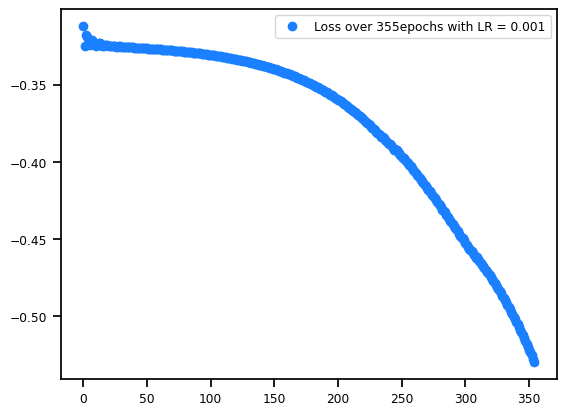

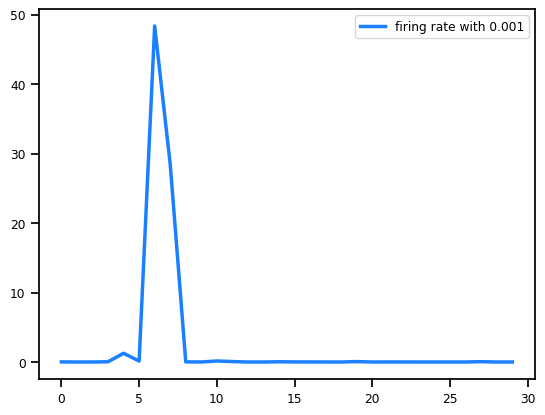

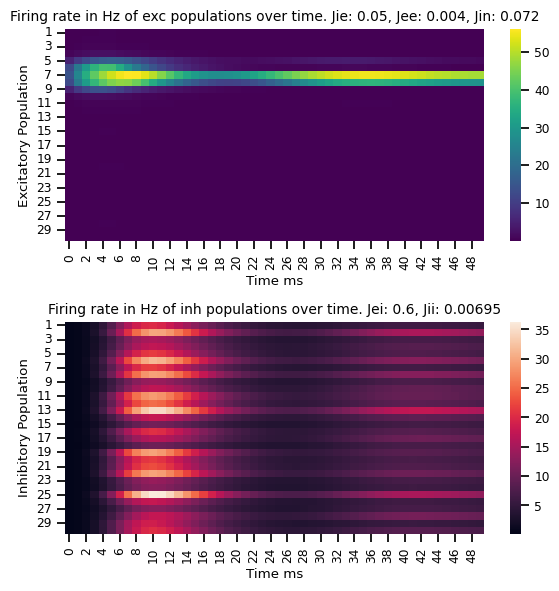

In [18]:
"""Jbad = {'Jee': 0.04, 'Jei': 0.001, 'Jie': 0.01, 'Jii': 0.4, 'Jin': .00595}
BadModel = Model(param, sim, Jbad)

optim_bad = run_optimization(BadModel, Input_NLLL, Target_idx_NLLL, "Optimized_bad" ,opti_name = "Adam" ,num_epoch =100, learning_rate =0.0001)
"""

LRs =[1E-3]#, 1E-3, 2E-3,5E-3 ,8E-3,7E-3]#[8E-3]# [1E-2, 9E-3 ,8E-3,7E-3]#, 1E-6 , 1E-7#0.01, #0.5, 0.1, 0.05, 0.01,  0.001,#0.0001, 
optim_list = []
for i, lr in enumerate(LRs):
    model_new = Model(param,sim, J1, Input_NLLL)
    result = run_optimization(model_new, Input_NLLL, Target_idx_NLLL, "Optimized_good_lr_" + f"{lr}"  ,opti_name = "Adam" ,num_epoch = 355, learning_rate = lr)
    optim_list.append(result)


C:\Users\knzga\AppData\Local\Temp\ipykernel_9424\1207876711.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(optim_list[i].losses.shape[0]), optim_list[i].losses.detach().numpy(), 'bo', color = color_l, label = f'Loss for {LRs[i]}')


Text(0.5, 1.0, 'Loss over 355 epochs')

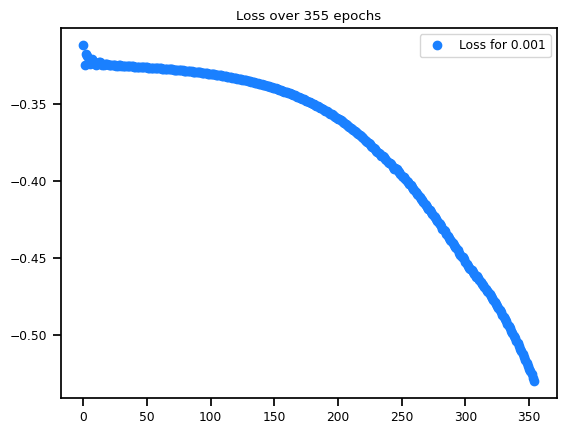

In [19]:
optim_list =optim_list

for i in range(0, len(optim_list)):
    """    r = np.round(np.random.rand(),1)
        g = np.round(np.random.rand(),1)
        b = np.round(np.random.rand(),1)"""
    color_l = optim_list[i].color_list# [r,g,b]
    plt.plot(np.arange(optim_list[i].losses.shape[0]), optim_list[i].losses.detach().numpy(), 'bo', color = color_l, label = f'Loss for {LRs[i]}')

plt.legend()
plt.title(f"Loss over {optim_list[i].losses.shape[0]} epochs")

<function matplotlib.pyplot.show(close=None, block=None)>

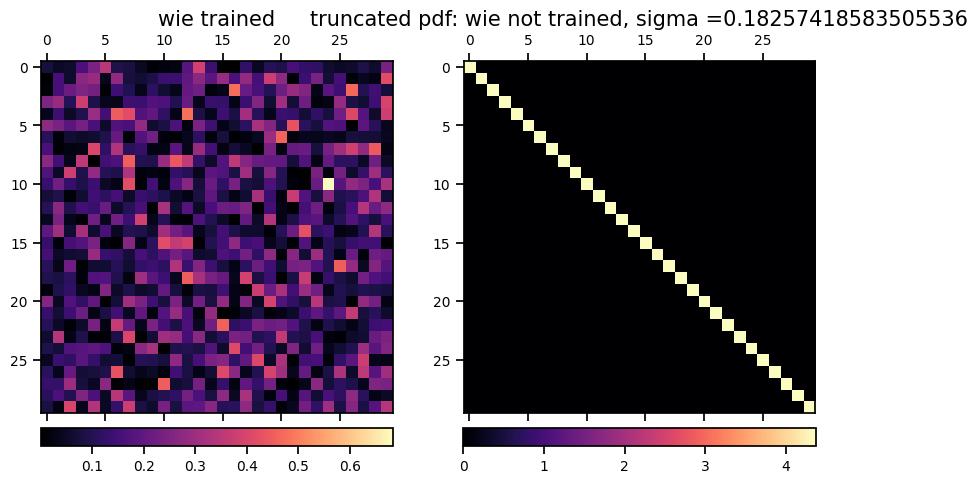

In [20]:
lower, upper = 0., np.inf
mu, sigma = 0, 1/np.sqrt(param.N)#random.randint(1, 30), random.uniform(0.1, 5)
wie = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
wie_pdf =wie.pdf(pop- pop[:, np.newaxis])

cmap = 'magma'

wie_train = list(model.parameters())[0].detach().numpy()
fig2, ax_t = plt.subplots(1,2, figsize = (10, 5))
ax1 = ax_t[0].matshow(wie_train, cmap = cmap)
ax1.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax_t[0].set_title("wie trained", size = subtitle_size-4)

ax2 = ax_t[1].matshow(wie_pdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax2.figure.axes[1].tick_params(axis="both", labelsize= 10) 
ax_t[1].set_title(f"truncated pdf: wie not trained, sigma ={sigma}", size = subtitle_size-4)
fig.colorbar(ax1,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
plt.show


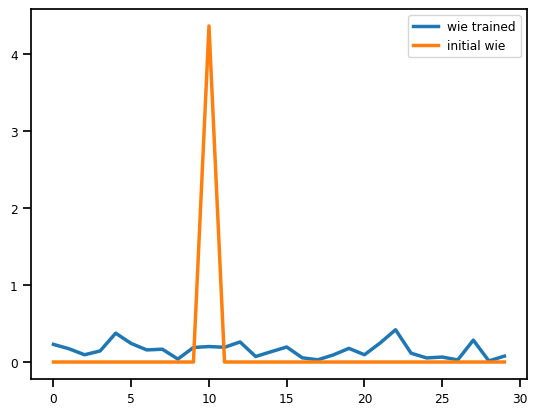

In [36]:
plt.plot(np.arange(30), wie_train[10], label = "wie trained")
plt.plot(np.arange(30), wie_pdf[10], label = "initial wie")
plt.legend()

### Test new Learning rate

C:\Users\knzga\AppData\Local\Temp\ipykernel_13012\1040605831.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)


Epoch [1/480], Loss: -0.3120250403881073
Epoch [2/480], Loss: -0.32473644614219666
Epoch [3/480], Loss: -0.31770431995391846
Epoch [4/480], Loss: -0.31914836168289185
Epoch [5/480], Loss: -0.32393473386764526
Epoch [6/480], Loss: -0.32447102665901184
Epoch [7/480], Loss: -0.322175532579422
Epoch [8/480], Loss: -0.3211408257484436
Epoch [9/480], Loss: -0.3223089277744293
Epoch [10/480], Loss: -0.3242165446281433
Epoch [11/480], Loss: -0.32498225569725037
Epoch [12/480], Loss: -0.3240969777107239
Epoch [13/480], Loss: -0.32307082414627075
Epoch [14/480], Loss: -0.3233368396759033
Epoch [15/480], Loss: -0.32445403933525085
Epoch [16/480], Loss: -0.32513198256492615
Epoch [17/480], Loss: -0.32487109303474426
Epoch [18/480], Loss: -0.324266254901886
Epoch [19/480], Loss: -0.3240976333618164
Epoch [20/480], Loss: -0.3245360553264618
Epoch [21/480], Loss: -0.32513174414634705
Epoch [22/480], Loss: -0.32532885670661926
Epoch [23/480], Loss: -0.325048565864563
Epoch [24/480], Loss: -0.324764102

C:\Users\knzga\AppData\Local\Temp\ipykernel_13012\2290438071.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', color = color_l, label = f'Training Loss for a learning rate of {learning_rate}')


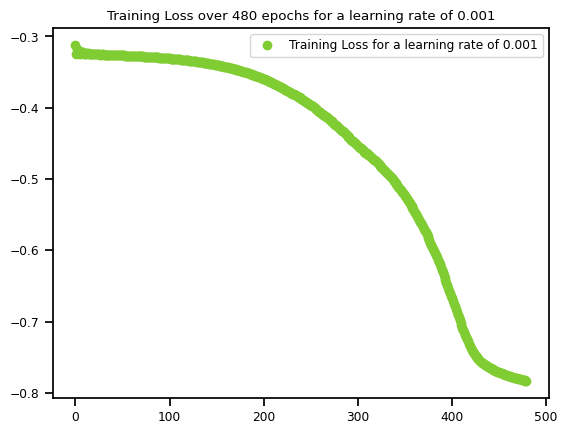

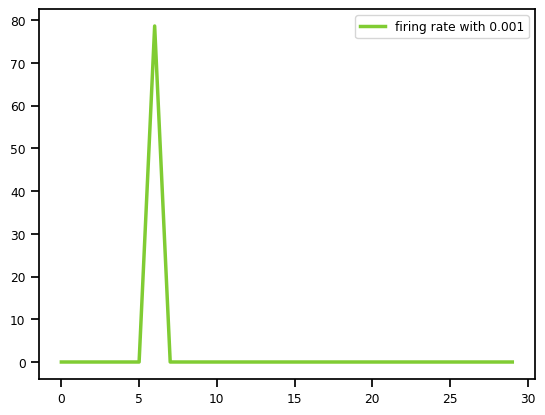

In [21]:
model = Model(param=param, sim=sim, dicJ= J1, In = Input_NLLL)
model.initiate_state()
num_epoch = 480
losses = torch.zeros(num_epoch)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
logsoft = nn.LogSoftmax(dim=1)
learning_rate = 0.001 #0.009#0.01
early_stopper = EarlyStopper(patience=20, min_delta=2)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

"""optim.SGD(model.parameters(),
                      lr=0.0001, weight_decay = 0.001) 
                       """


T = Target_idx_NLLL 
Input = Input_NLLL 


model.train()
for epoch in range(num_epoch):
    model.initiate_state()
    optimizer.zero_grad()  
    P = torch.zeros(Input.shape)   
    I = torch.zeros(Input.shape) 
    dPdt = torch.zeros_like(Input)  

    count = 0
    for i, b in enumerate(T):
        count +=1
        P[i,:], I[i,:], dPdt[i,:], dridt, ampa, gaba = model(Input[int(i),:])
        if count == train_IN.shape[1]: #if we end the simulation time and go to the next batch
            count = 0
            model.initiate_state()
    
    
    #P2 =F.softmax(P, dim=1) # make_it_proba(P)   #P2 = F.softmax(P, dim=1) #P2 = logsoft(P)#.t()
    #P2 = logsoft(P)
    P2 = make_it_proba(P)
    #loss = easyLoss(P2, train_Targets_reshaped)
    #loss = criterion(P2, T.long())  #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # 
    loss = custom_loss_(P, T, dPdt)
    loss.backward()
    optimizer.step()
    #ic(torch.max(P), torch.min(P),torch.mean(P))
    #ic(torch.max(P2), torch.min(P2), torch.mean(P2))

    if early_stopper.early_stop(loss):             
        break
    losses[epoch] = loss
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()
r = np.round(np.random.rand(),1)
g = np.round(np.random.rand(),1)
b = np.round(np.random.rand(),1)
color_l = [r,g,b]
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', color = color_l, label = f'Training Loss for a learning rate of {learning_rate}')
plt.title(f"Training Loss over {num_epoch} epochs for a learning rate of {learning_rate}")
plt.legend()
plt.show()

plt.plot(np.arange(P.shape[1]), P[50,:].detach().numpy(), color = color_l, label = f'firing rate with {learning_rate}')
plt.legend()
plt.show()
    #for par in model.parameters():
      #print(par.grad)

save_weights(model, "Optimized.pth")

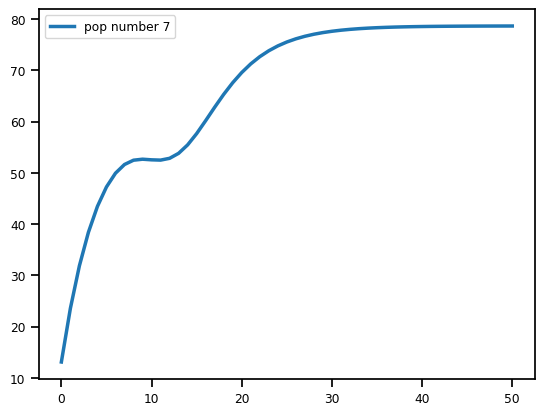

In [22]:
plt.plot(np.arange(P[:51,:].detach().numpy().shape[0]), P[:51,6].detach().numpy(), label = "pop number 7")
plt.legend()

#### Evaluation of the new parameters:

In [23]:
newModel = Model(param, sim, J1, In[:,3:-3])
trained_model = load_weights(newModel, "Optimized.pth")
#ic(trained_model.state_dict(), J1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#P_t, I_t, dP_tdt = run_model_across_batch(Input_NLLL[:,3:-3], len_sim, model)

C:\Users\knzga\AppData\Local\Temp\ipykernel_13012\1040605831.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)


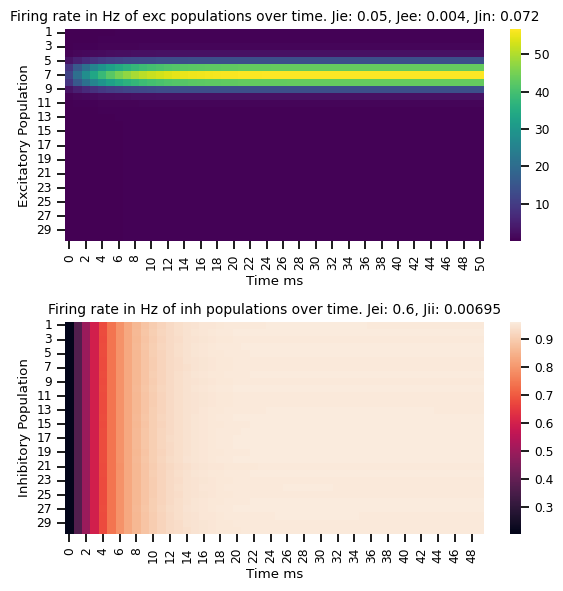

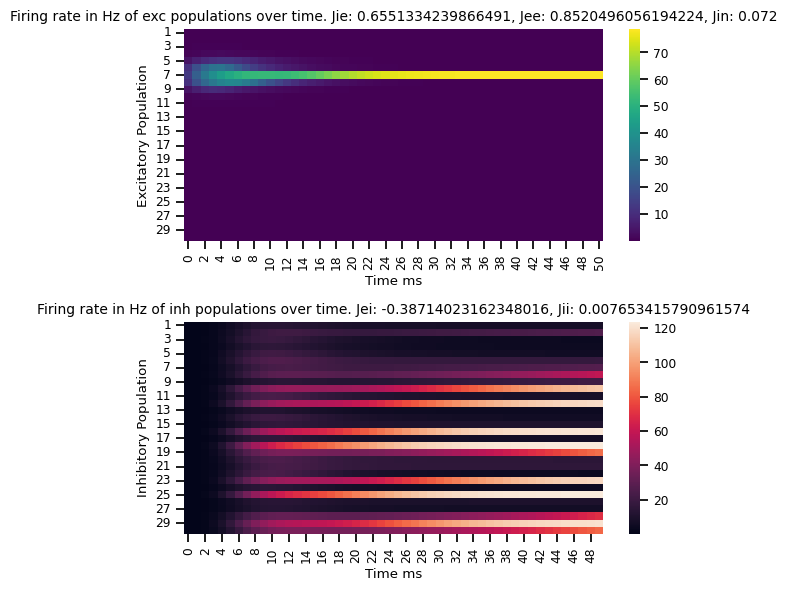

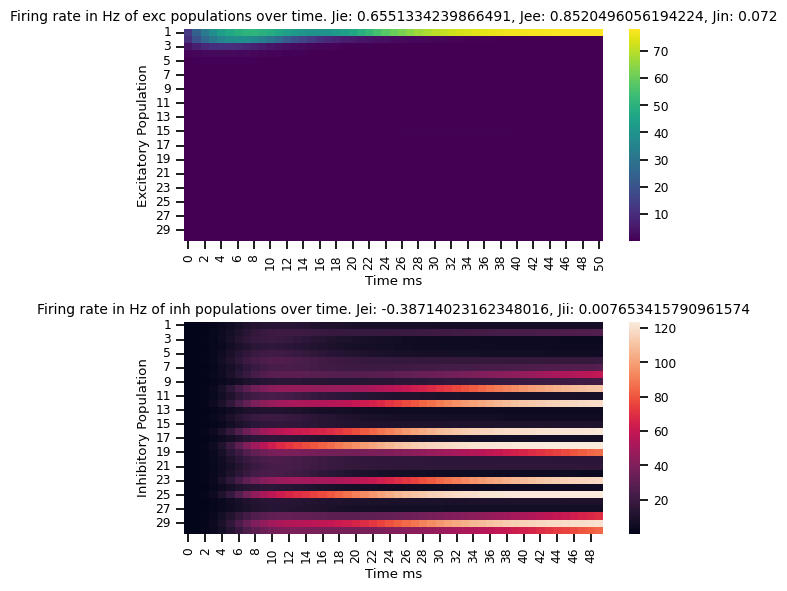

In [24]:
# Prediction before training
HeatMap(P0[:51,:].detach().numpy(), I0[0:50,:].detach().numpy(), J1)
# Prediction after training
J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P[:51,:].detach().numpy(), I[:50,:].detach().numpy(), J2)
J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P[102:153,:].detach().numpy(), I[:50,:].detach().numpy(), J2)

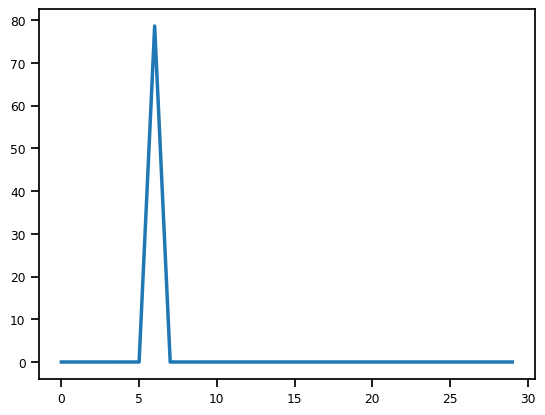

In [25]:
plt.plot(np.arange(30),P[49,:].detach().numpy())

C:\Users\knzga\AppData\Local\Temp\ipykernel_13012\1040605831.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)


<function matplotlib.pyplot.show(close=None, block=None)>

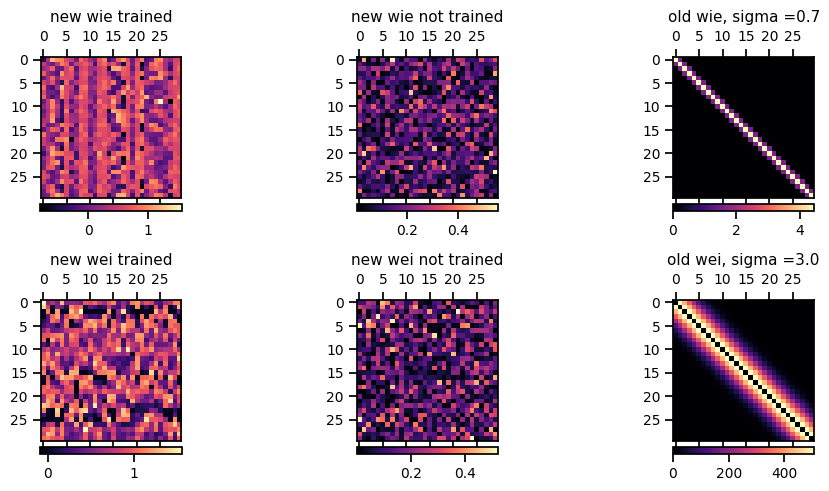

In [28]:
lower, upper = 0., np.inf
mu, sigma = 0, 1/np.sqrt(param.N)#random.randint(1, 30), random.uniform(0.1, 5)
wie_pdf = init_random_matrix(param.N) #truncated_normal(param.N, mu, sigma)
wei_pdf = init_random_matrix(param.N) #truncated_normal(param.N, mu, sigma)
sigma = .7#param.sEI
wie_before = gaussian_filter(sigma, int(param.N))
wei_before = dog_filter(3.,param.N)

subtitle_size = 15
#cmap = 'viridis'
#cmap = 'plasma'
cmap = 'magma'

wie_train = trained_model.wie.detach().numpy() #list(model.parameters())[0].detach().numpy()
wei_train = trained_model.wei.detach().numpy() #list(model.parameters())[0].detach().numpy()

fig2, ax_t = plt.subplots(2,3, figsize = (10, 5))
ax1 = ax_t[0][0].matshow(wie_train, cmap = cmap)
ax1.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax_t[0][0].set_title("new wie trained", size = subtitle_size-4)

ax2 = ax_t[0][1].matshow(wie_pdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax2.figure.axes[1].tick_params(axis="both", labelsize= 10) 
 # np.round(sigma, 3)
ax_t[0][1].set_title(f"new wie not trained", size = subtitle_size-4)

ax3 = ax_t[0][2].matshow(wie_before, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax3.figure.axes[2].tick_params(axis="both", labelsize= 10) 
ax_t[0][2].set_title(f"old wie, sigma ={sigma}", size = subtitle_size-4)

ax4 = ax_t[1][0].matshow(wei_train, cmap = cmap)
ax4.figure.axes[3].tick_params(axis="both", labelsize= 10) 
ax_t[1][0].set_title("new wei trained", size = subtitle_size-4)

ax5 = ax_t[1][1].matshow(wei_pdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax5.figure.axes[4].tick_params(axis="both", labelsize= 10) 
 # np.round(sigma, 3)
ax_t[1][1].set_title(f"new wei not trained", size = subtitle_size-4)

ax6 = ax_t[1][2].matshow(wei_before, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax6.figure.axes[5].tick_params(axis="both", labelsize= 10) 
ax_t[1][2].set_title(f"old wei, sigma ={param.sOut}", size = subtitle_size-4)

fig.colorbar(ax1,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax3,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax4,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax5,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax6,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
plt.tight_layout()
plt.show


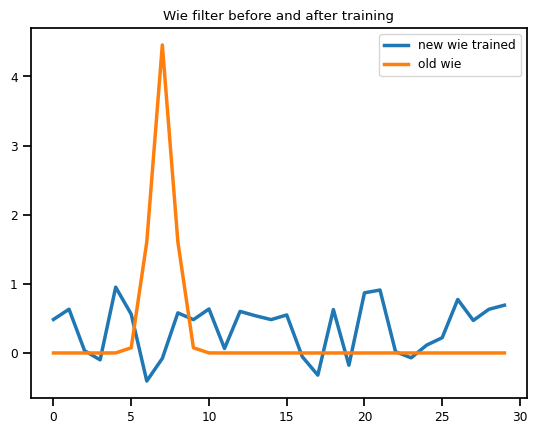

In [49]:
popu = 7
plt.plot(np.arange(30), wie_train[popu], label = "new wie trained")
plt.plot(np.arange(30), wie_before[popu], label = "old wie")
#plt.plot(np.arange(30), wie_pdf[popu], label = "new wie untrained")
plt.title("Wie filter before and after training")
plt.legend()

#### Evaluation of the new parameters:

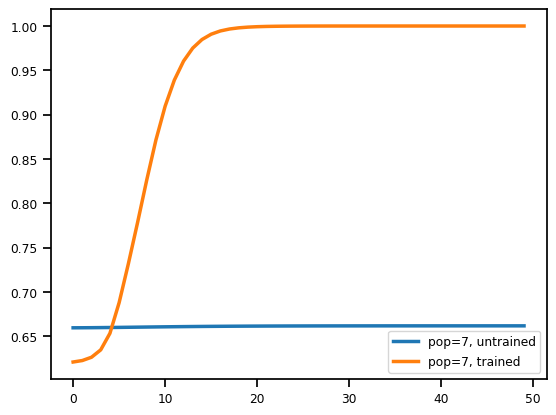

In [50]:
P0_np = np.array(P0.detach().numpy())
PT_np = np.array(P.detach().numpy())

P0_norm = preprocessing.normalize(P0_np, axis= 1) 
PT_norm = preprocessing.normalize(PT_np, axis= 1) 

pop =6
plt.plot(np.arange(0,50), P0_norm[:50,pop], label = f"pop={pop +1}, untrained")
plt.plot(np.arange(0,50), PT_norm[:50,pop], label = f"pop={pop +1}, trained")
plt.legend()

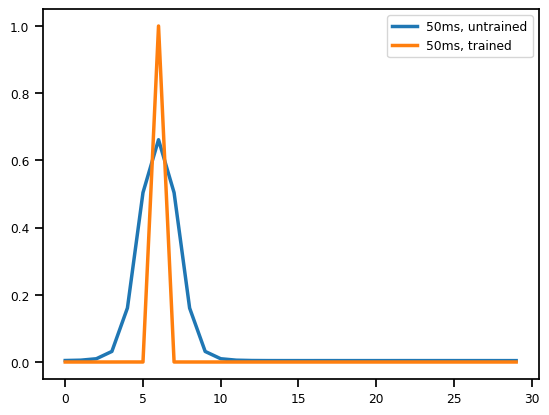

In [51]:

# Normalized plot
t1 = 50
t2 = 50
t3 = 25#1250
   
#plot_normalized_plot(P0, P, t1)
plot_normalized_plot(P0, P, t2)
#plot_normalized_plot(P0, P_t, t3)

plt.legend()
plt.show()



Bad parameters

In [52]:
Jbad = {'Jee': 0.04, 'Jei': 0.001, 'Jie': 0.01, 'Jii': 0.4, 'Jin': .00595}
BadModel = Model(param, sim, Jbad, In)

optim_bad = run_optimization(BadModel, Input_NLLL, Target_idx_NLLL, "Optimized_bad" ,opti_name = "Adam" ,num_epoch =60, learning_rate =0.005)# 0.01

C:\Users\knzga\AppData\Local\Temp\ipykernel_1320\1040605831.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)
ic| torch.max(P): tensor(40.3138, grad_fn=<MaxBackward1>)


Epoch [1/60], Loss: -0.32395005226135254, Learning rate:0.005


ic| torch.max(P): tensor(0.8502, grad_fn=<MaxBackward1>)


Epoch [2/60], Loss: 26.415544509887695, Learning rate:0.005


C:\Users\knzga\AppData\Local\Temp\ipykernel_11760\2603301172.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')


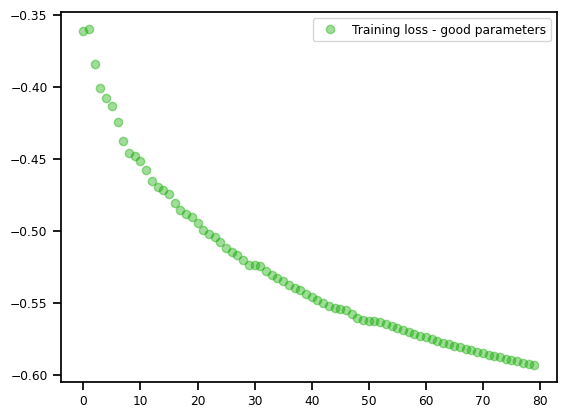

In [49]:
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')
plt.legend()

C:\Users\knzga\AppData\Local\Temp\ipykernel_16960\3463038787.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')


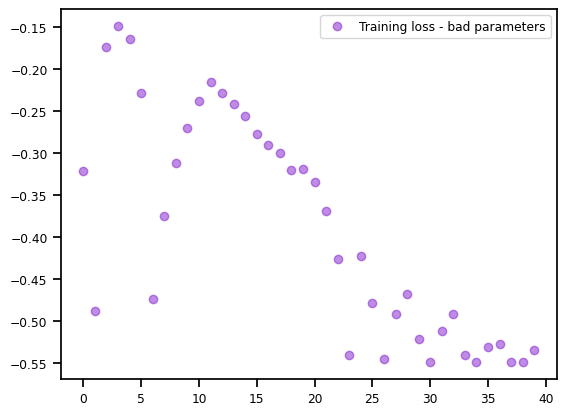

In [ ]:
plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
plt.legend()

C:\Users\knzga\AppData\Local\Temp\ipykernel_16960\345714583.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
C:\Users\knzga\AppData\Local\Temp\ipykernel_16960\345714583.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')


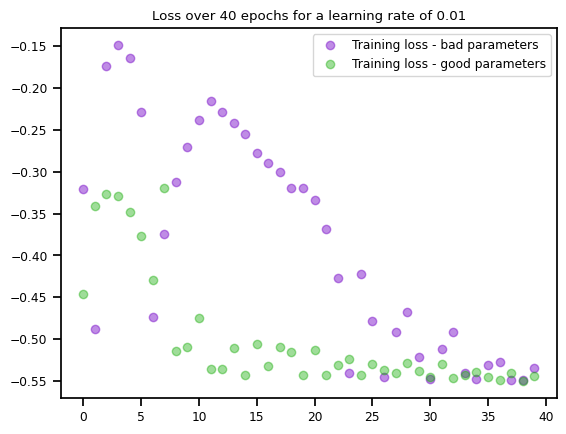

In [ ]:

plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')
plt.title(f"Loss over {num_epoch} epochs for a learning rate of {learning_rate}")
plt.legend()
plt.show()

In [50]:
Jbad = {'Jee': 0.04, 'Jei': 0.001, 'Jie': 0.01, 'Jii': 0.4, 'Jin': .00595}
BadModel_2 = Model(param, sim, Jbad, In)
P_Bad0, I_Bad0,dPbad_dt0 = run_model_across_batch(Input_NLLL, len_sim, BadModel_2)

In [51]:

BadModel_trained = load_weights(BadModel, "Optimized_bad.pth")
#ic(trained_model.state_dict(), J1)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
P_Bad, I_Bad,dPbad_dt = run_model_across_batch(Input_NLLL, len_sim, BadModel)
P_Bad_t, I_Bad_t,dPbad_dt_t = run_model_across_batch(Input_NLLL, len_sim, BadModel_trained)

ic| torch.max(P_Bad_t): tensor(53.6435, grad_fn=<MaxBackward1>)
ic| torch.max(P_Bad): tensor(53.6435, grad_fn=<MaxBackward1>)


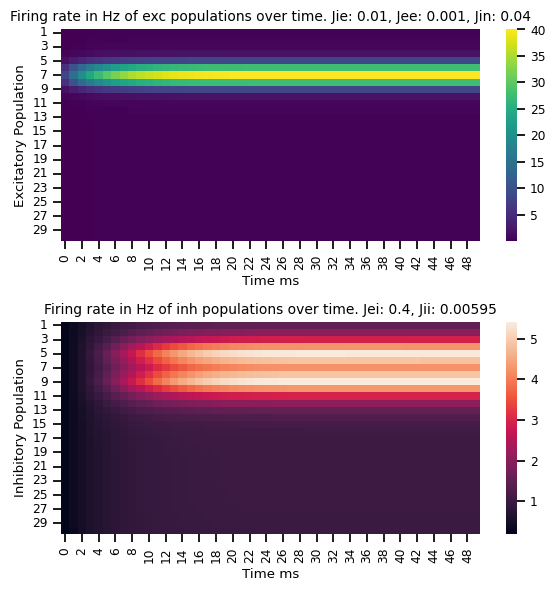

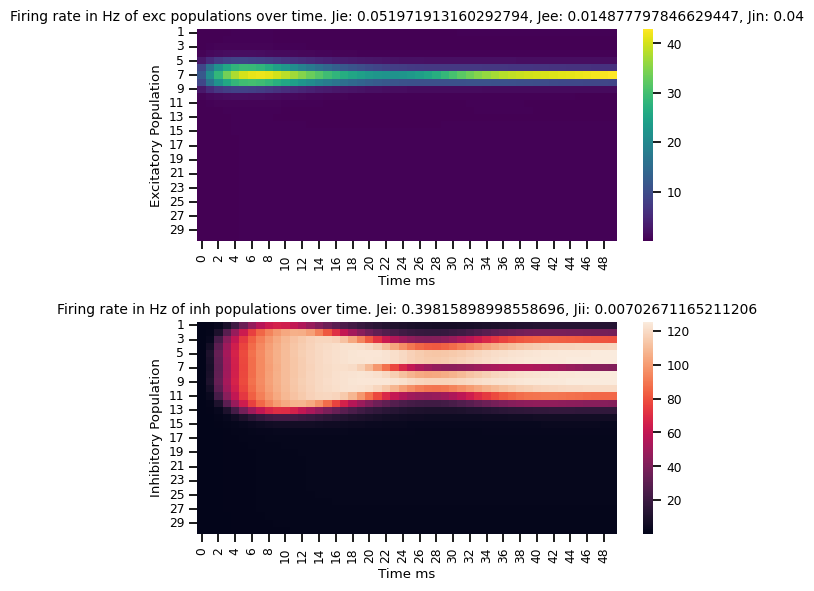

In [53]:
ic(torch.max(P_Bad_t))
ic(torch.max(P_Bad))

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P_Bad0[:50,:].detach().numpy(), I_Bad0[:50,:].detach().numpy(), Jbad)
J2= {'Jee': BadModel_trained.Jee.detach().numpy(), 'Jei': BadModel_trained.Jei.detach().numpy(), 'Jie': BadModel_trained.Jie.detach().numpy(), 'Jii': BadModel_trained.Jii.detach().numpy(), 'Jin': BadModel_trained.Jin.detach().numpy()}
HeatMap(P_Bad[:50,:].detach().numpy(), I_Bad[:50,:].detach().numpy(), J2)

In [55]:
legend = (" bad params trained", " good params trained")
legend[0]

' bad params trained'

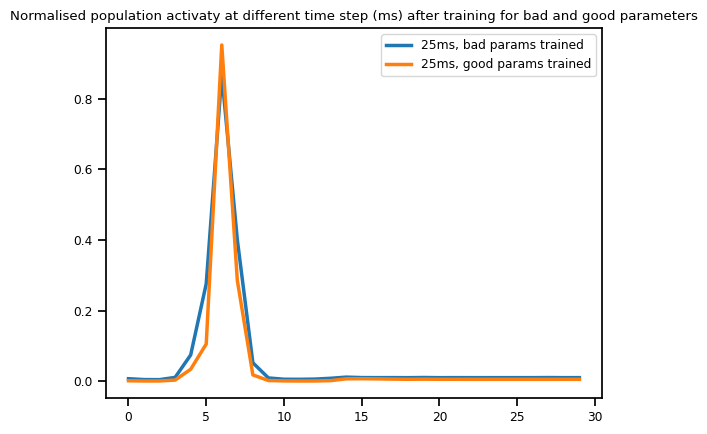

In [56]:
t2 = 25#16
t3 = 49
#plot_normalized_plot(P_Bad0, P_Bad, t1)
#plot_normalized_plot(P_Bad, P_Bad_t, t2)
#plot_normalized_plot(P_Bad0, P_Bad, t3)
plot_normalized_plot(P_Bad,P, t2, legend)
#plt.title(f"Normalised population activaty at different time step (ms) with bad parameters, before and after training")
plt.title(f"Normalised population activaty at different time step (ms) after training for bad and good parameters")

plt.legend()

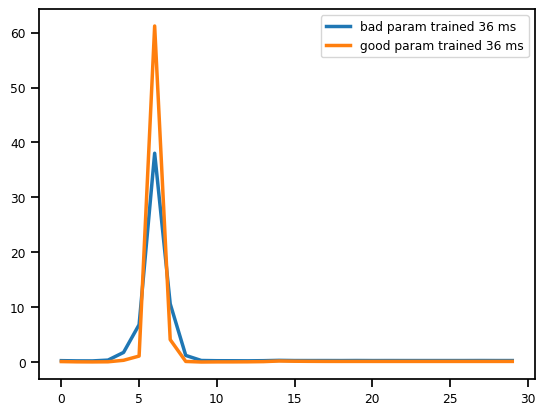

In [57]:
t = 36
t2= 4
#plt.plot(np.arange((r_e[t,:].detach().numpy()).shape[0]), r_e[t,:].detach().numpy(), label = f"time {t} ms")
#plt.plot(np.arange((r_e[t2,:].detach().numpy()).shape[0]), r_e[t2,:].detach().numpy(), label = f"time {t2} ms")
#plt.plot(np.arange((P_Bad[t2,:].detach().numpy()).shape[0]), P_Bad[t2,:].detach().numpy(), label = f"bad param {t2} ms")
#plt.plot(np.arange((P_Bad_t[t2,:].detach().numpy()).shape[0]), P_Bad_t[t2,:].detach().numpy(), label = f"bad param trained {t2} ms")
plt.plot(np.arange((P_Bad[t,:].detach().numpy()).shape[0]), P_Bad[t,:].detach().numpy(), label = f"bad param trained {t} ms")
plt.plot(np.arange((P[t,:].detach().numpy()).shape[0]), P[t,:].detach().numpy(), label = f"good param trained {t} ms")
plt.legend()

